In [1]:
# In The Name of God - 22/10/1401
# Public to Reference Conversion by Simple Autoencoder - 1
# Dataset UCI-Adult
# Notes:
#      1- without last layer of decoder (tanh) - bad and ignored!! (but we trained this in thesis1)

In [2]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files
isFirstRun = False
lastRunEpochNumber = 200
manual_seed = 20

learning_rate = 0.001 #0.2
batch_size = 64

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasets'

data_dir = 'adult'
save_dir = 'uci-p2r-ae-rev2-model2'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Number of training epochs
num_epochs = 1000 #100

In [4]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# download dataset and unzip

if files_not_ready:
    dataset_csv_path = dataset_folder_path + '/adult.csv'

    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_csv_path, data_dir + r'/adult.csv')

try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

data folder created successfully
Error: File exists


In [7]:
# Define transforms
# train_transforms = transforms.Compose(transforms.ToTensor())
# test_transforms = transforms.Compose(transforms.ToTensor())

In [8]:
#PreProcess dataset:
df = pd.read_csv(os.path.join(data_dir,'adult.csv'))
df = df.replace({'?':np.nan})
df = df.dropna()
df1 = pd.get_dummies(df)
train, test = train_test_split(df1, test_size = 0.2, random_state = 42)
utility_train_true_labels = np.array(train[['income_<=50K','income_>50K']])
utility_test_true_labels = np.array(test[['income_<=50K','income_>50K']])
private_train_true_labels = np.array(train[['gender_Male', 'gender_Female']])
private_test_true_labels = np.array(test[['gender_Male', 'gender_Female']])
x_train = (train.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
x_test = (test.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(x_train)
x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

In [9]:
from torch.utils.data import Dataset

class UciAdultDataset(Dataset):
    def __init__(self, X, Y_p, Y_u):#, transform):
        self.X = X
        self.Y_p = Y_p
        self.Y_u = Y_u
        # self.transform = transform
        
    def __len__(self):
        return len(self.Y_p)
    
    def __getitem__(self, idx):
        data = self.X[idx]
        label_p = self.Y_p[idx]
        label_u = self.Y_u[idx]
        data = torch.from_numpy(data)
        label_p = torch.from_numpy(label_p)
        label_u = torch.from_numpy(label_u)
        return data, label_p, label_u

In [10]:
# Load Datas
train_set = UciAdultDataset(x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
test_set = UciAdultDataset(x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=workers, drop_last=True)

In [11]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  # print(classname)
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [13]:
# Encoder Model
# class Encoder(nn.Module):
#     def __init__(self, ngpu):
#         super(Encoder, self).__init__()
#         self.ngpu = ngpu
        
#         # input is 102
#         # classifier: (gender)
#         self.fllc1 = nn.Linear(102, 256)
#         self.actv1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(p=0.2) #p=0.5
#         self.fllc2 = nn.Linear(256, 256)
#         self.actv2 = nn.ReLU(inplace=True)
#         self.dropout2 = nn.Dropout(p=0.3) #p=0.5
#         self.fllc3 = nn.Linear(256, 256)
#         self.actv3 = nn.ReLU(inplace=True)
#         #self.dropout3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc4 = nn.Linear(256, 128)
#         self.actv4 = nn.LogSoftmax(dim=1)

#         # split features: 128 -> 126 + 2 (male/female)
#         # first classifier: (gender)
#         self.fllc_male_features1 = nn.Linear(128, 64)
#         self.actv_male_features1 = nn.ReLU(inplace=True)
#         self.dropout_male_features1 = nn.Dropout(p=0.2) #p=0.2
#         self.fllc_male_features2 = nn.Linear(64, 32)
#         self.actv_male_features2 = nn.ReLU(inplace=True)
#         self.dropout_male_features2 = nn.Dropout(p=0.3) #p=0.3
#         self.fllc_male_features3 = nn.Linear(32, 8)
#         self.actv_male_features3 = nn.ReLU(inplace=True)
#         #self.dropout_male_features3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc_male_features4 = nn.Linear(8, 2)
#         self.actv_male_features4 = nn.LogSoftmax(dim=1)
#         # other features
#         self.fllc_other_features1 = nn.Linear(128, 128)
#         self.actv_other_features1 = nn.ReLU(inplace=True)
#         self.dropout_other_features1 = nn.Dropout(p=0.2) #p=0.2
#         self.fllc_other_features2 = nn.Linear(128, 128)
#         self.actv_other_features2 = nn.ReLU(inplace=True)
#         self.dropout_other_features2 = nn.Dropout(p=0.3) #p=0.3
#         self.fllc_other_features3 = nn.Linear(128, 128)
#         self.actv_other_features3 = nn.ReLU(inplace=True)
#         #self.dropout_other_features3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc_other_features4 = nn.Linear(128, 126)
#         self.actv_other_features4 = nn.ReLU(inplace=True)
#         # aggregate features for output

#     def forward(self, x):
#         # Part 1:
#         x = self.fllc1(x)
#         x = self.actv1(x)
#         x = self.dropout1(x)
#         x = self.fllc2(x)
#         x = self.actv2(x)
#         x = self.dropout2(x)
#         x = self.fllc3(x)
#         x = self.actv3(x)
#         # x = self.dropout3(x)
#         x = self.fllc4(x)
#         x = self.actv4(x)
#         # Part 2:
#         # first classifier: (gender)
#         y1 = self.fllc_male_features1(x)
#         y1 = self.actv_male_features1(y1)
#         y1 = self.dropout_male_features1(y1)
#         y1 = self.fllc_male_features2(y1)
#         y1 = self.actv_male_features2(y1)
#         y1 = self.dropout_male_features2(y1)
#         y1 = self.fllc_male_features3(y1)
#         y1 = self.actv_male_features3(y1)
#         # y1 = self.dropout_male_features3(y1)
#         y1 = self.fllc_male_features4(y1)
#         y1 = self.actv_male_features4(y1)
#         # other features
#         y3 = self.fllc_other_features1(x) 
#         y3 = self.actv_other_features1(y3)
#         y3 = self.dropout_other_features1(y3)
#         y3 = self.fllc_other_features2(y3) 
#         y3 = self.actv_other_features2(y3)
#         y3 = self.dropout_other_features2(y3)
#         y3 = self.fllc_other_features3(y3) 
#         y3 = self.actv_other_features3(y3)
#         # y3 = self.dropout_other_features3(y3)
#         y3 = self.fllc_other_features4(y3)
#         y3 = self.actv_other_features4(y3)
#         return y1, y3

class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        self.fllc1 = nn.Linear(102, 128)
        self.actv1 = nn.ReLU(inplace=True)
        # self.dropout1 = nn.Dropout(p=0.2) #p=0.5
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)
        # self.dropout2 = nn.Dropout(p=0.3) #p=0.5
        # self.fllc3 = nn.Linear(256, 256)
        # self.actv3 = nn.ReLU(inplace=True)
        #self.dropout3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc4 = nn.Linear(128, 64)
        self.actv4 = nn.ReLU(inplace=True)

        # split features: 128 -> 126 + 2 (male/female)
        # first classifier: (gender)
        # self.fllc_male_features1 = nn.Linear(128, 64)
        # self.actv_male_features1 = nn.ReLU(inplace=True)
        # self.dropout_male_features1 = nn.Dropout(p=0.2) #p=0.2
        self.fllc_male_features2 = nn.Linear(64, 32)
        self.actv_male_features2 = nn.ReLU(inplace=True)
        # self.dropout_male_features2 = nn.Dropout(p=0.3) #p=0.3
        self.fllc_male_features3 = nn.Linear(32, 8)
        self.actv_male_features3 = nn.ReLU(inplace=True)
        #self.dropout_male_features3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc_male_features4 = nn.Linear(8, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(64, 64)
        self.actv_other_features1 = nn.ReLU(inplace=True)
        # self.dropout_other_features1 = nn.Dropout(p=0.2) #p=0.2
        self.fllc_other_features2 = nn.Linear(64, 62)
        self.actv_other_features2 = nn.ReLU(inplace=True)
        # self.dropout_other_features2 = nn.Dropout(p=0.3) #p=0.3
        # self.fllc_other_features3 = nn.Linear(128, 128)
        # self.actv_other_features3 = nn.ReLU(inplace=True)
        #self.dropout_other_features3 = nn.Dropout(p=0.5) #p=0.4
        # self.fllc_other_features4 = nn.Linear(128, 126)
        # self.actv_other_features4 = nn.ReLU(inplace=True)
        # aggregate features for output

    def forward(self, x):
        # Part 1:
        x = self.fllc1(x)
        x = self.actv1(x)
        # x = self.dropout1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        # x = self.dropout2(x)
        # x = self.fllc3(x)
        # x = self.actv3(x)
        # x = self.dropout3(x)
        x = self.fllc4(x)
        x = self.actv4(x)
        # Part 2:
        # first classifier: (gender)
        # y1 = self.fllc_male_features1(x)
        # y1 = self.actv_male_features1(y1)
        # y1 = self.dropout_male_features1(y1)
        y1 = self.fllc_male_features2(x)
        y1 = self.actv_male_features2(y1)
        # y1 = self.dropout_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        # y1 = self.dropout_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # other features
        y3 = self.fllc_other_features1(x) 
        y3 = self.actv_other_features1(y3)
        # y3 = self.dropout_other_features1(y3)
        y3 = self.fllc_other_features2(y3) 
        y3 = self.actv_other_features2(y3)
        # y3 = self.dropout_other_features2(y3)
        # y3 = self.fllc_other_features3(y3) 
        # y3 = self.actv_other_features3(y3)
        # y3 = self.dropout_other_features3(y3)
        # y3 = self.fllc_other_features4(y3)
        # y3 = self.actv_other_features4(y3)
        return y1, y3

In [14]:
# Decoder Model
# class Decoder(nn.Module):
#     def __init__(self, ngpu):
#         super(Decoder, self).__init__()
#         self.ngpu = ngpu
        
#         # input size is 64
#         self.fllc1 = nn.Linear(128, 256)
#         self.actv1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(p=0.2) #p=0.5
#         self.fllc2 = nn.Linear(256, 256)
#         self.actv2 = nn.ReLU(inplace=True)
#         self.dropout2 = nn.Dropout(p=0.3) #p=0.5
#         self.fllc3 = nn.Linear(256, 256)
#         self.actv3 = nn.ReLU(inplace=True)
#         # self.dropout3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc4 = nn.Linear(256, 102)
#         self.actv4 = nn.Tanh()

#     def forward(self, x):
#         x = self.fllc1(x)
#         x = self.actv1(x)
#         x = self.dropout1(x)
#         x = self.fllc2(x)
#         x = self.actv2(x)
#         x = self.dropout2(x)
#         x = self.fllc3(x)
#         x = self.actv3(x)
#         # x = self.dropout3(x)
#         x = self.fllc4(x)
#         x = self.actv4(x)
#         return x
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        
        # input size is 64
        self.fllc1 = nn.Linear(64, 128)
        self.actv1 = nn.ReLU(inplace=True)
        # self.dropout1 = nn.Dropout(p=0.2) #p=0.5
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)
        # self.dropout2 = nn.Dropout(p=0.3) #p=0.5
        # self.fllc3 = nn.Linear(256, 256)
        # self.actv3 = nn.ReLU(inplace=True)
        # self.dropout3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc4 = nn.Linear(128, 102)
        self.actv4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fllc1(x)
        x = self.actv1(x)
        # x = self.dropout1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        # x = self.dropout2(x)
        # x = self.fllc3(x)
        # x = self.actv3(x)
        # x = self.dropout3(x)
        x = self.fllc4(x)
        x = self.actv4(x)
        return x

In [15]:
# AE Model
class AEModel(nn.Module):
    def __init__(self, ngpu):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def forward(self, x):
        y1, y3 = self.encoder(x)
        y = torch.cat((y1, y3), 1)
        x = self.decoder(y)
        return x, y1

In [16]:
# Create the AE
netAE = AEModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netAE.apply(weights_init)


AEModel(
  (encoder): Encoder(
    (fllc1): Linear(in_features=102, out_features=128, bias=True)
    (actv1): ReLU(inplace=True)
    (fllc2): Linear(in_features=128, out_features=128, bias=True)
    (actv2): ReLU(inplace=True)
    (fllc4): Linear(in_features=128, out_features=64, bias=True)
    (actv4): ReLU(inplace=True)
    (fllc_male_features2): Linear(in_features=64, out_features=32, bias=True)
    (actv_male_features2): ReLU(inplace=True)
    (fllc_male_features3): Linear(in_features=32, out_features=8, bias=True)
    (actv_male_features3): ReLU(inplace=True)
    (fllc_male_features4): Linear(in_features=8, out_features=2, bias=True)
    (actv_male_features4): LogSoftmax(dim=1)
    (fllc_other_features1): Linear(in_features=64, out_features=64, bias=True)
    (actv_other_features1): ReLU(inplace=True)
    (fllc_other_features2): Linear(in_features=64, out_features=62, bias=True)
    (actv_other_features2): ReLU(inplace=True)
  )
  (decoder): Decoder(
    (fllc1): Linear(in_feature

In [17]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in netAE.parameters())
print(f"{total_params:,} training parameters.")

86,494 training parameters.


In [18]:
# Initialize BCELoss function
criterion = nn.MSELoss()
criterion_male_features = nn.NLLLoss() # nn.MSELoss()
optimizer = optim.Adam(netAE.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [19]:
# Function - Save:
def save_model(name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [20]:
# Function - Load:
def load_model(name, number, model, device):
  
  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [21]:
# Function - Delete file:
def delete_file(name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [22]:
# Save Start Checkpoint
# Comment It for next run!
if(isFirstRun):
  res = {'train_losses': [],
         'valid_losses': [],
         'y1_train_losses': [],
         'y1_valid_losses': [],
         'test_mse': [],
         'test_y1_acc': [],
         'epoch_number': 0
        };
  save_model('ae', 0, netAE, res)

In [23]:
# Load Last Checkpoint:
ae_load = load_model('ae', lastRunEpochNumber, netAE, device)

train_losses = ae_load['res']['train_losses']
valid_losses = ae_load['res']['valid_losses']
y1_train_losses = ae_load['res']['y1_train_losses']
y1_valid_losses = ae_load['res']['y1_valid_losses']
test_mse = ae_load['res']['test_mse']
test_y1_acc = ae_load['res']['test_y1_acc']
last_epoch = ae_load['res']['epoch_number']

In [24]:
def extract_class_index(labels):
  return labels[:,0]

In [25]:
# Function - training function
def fit(netAE, train_loader, optimizer, criterion):
    print('Training')
    netAE.train()

    train_loss = 0
    y1_train_loss = 0

    # For each batch in the dataloader
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in prog_bar:
        inputs, labels = data[0], data[2]
        # added:
        labels = extract_class_index(labels)
        # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
        inputs = inputs.to(torch.float32)
        inputs, labels = inputs.to(device), labels.to(device)
        netAE.zero_grad()
        output, y1 = netAE(inputs)
        err = criterion(output, inputs)
        err_y1 = criterion_male_features(y1, labels)
        err.backward(retain_graph=True)
        err_y1.backward(retain_graph=True)
        optimizer.step()
        train_loss += err.item()
        y1_train_loss += err_y1.item()
    train_loss = train_loss / len(train_loader)
    y1_train_loss = y1_train_loss / len(train_loader)
    return train_loss, y1_train_loss

In [26]:
# Function - validation function
def validate(netAE, valid_loader, optimizer, criterion):
    print('Validating')
    netAE.eval()

    valid_loss = 0
    y1_valid_loss = 0
    # For each batch in the dataloader
    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[2]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            output, y1 = netAE(inputs)
            err = criterion(output, inputs)
            err_y1 = criterion_male_features(y1, labels)
            valid_loss += err.item()
            y1_valid_loss += err_y1.item()
    valid_loss = valid_loss / len(valid_loader)
    y1_valid_loss = y1_valid_loss / len(valid_loader)
    return valid_loss, y1_valid_loss

In [27]:
# Some test for dataset creation after using p2r

# x_train_inverse = standard_scaler.inverse_transform(x_train)

# inp, la1, la2 = next(iter(test_loader))

# print(inp[:,8][:20])
# inp = inp.to(torch.float32)
# inp = inp.to(device)
# outp, y1 = netAE(inp)
# print(outp[:,8][:20])

# outp = outp.detach()
# outp_inverse = standard_scaler.inverse_transform(outp)
# print(outp_inverse[:,8][:20])
# plt.hist(outp_inverse[:,8], bins='auto')

# for i in range(64):
#   for j in range(102):
#     if outp_inverse[i,j] >= 0.5:
#       outp_inverse[i,j] = 1
#     else:
#       outp_inverse[i,j] = 0

# print(outp_inverse[:,8][:20])
# plt.hist(outp_inverse[:,8], bins='auto')

In [28]:
# Calc Accuracy
def calcAccuracyTest(netAE, test_loader):
    print('Testing')
    netAE.to(device)
    print("Calculating Accuracy...")
    netAE.eval()
    mse_loss = 0
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[2]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            # a1, gender_label_top_class = labels.topk(1, dim=1)
            output, y1 = netAE(inputs)
            mse = criterion(output, inputs)
            ps_y1 = torch.exp(y1)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == gender_label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == labels.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            mse_loss += mse.item()
            y1_accuracy += (acc_y1 / len(equals_y1))
    mse_loss = mse_loss / len(test_loader)
    y1_accuracy = y1_accuracy / len(test_loader)
    return mse_loss, y1_accuracy

In [29]:
# Training Loop
netAE.to(device)
calc_every_epoch = 1
save_every_epoch = 1

start = time.time()
print("Starting Training Loop...")

for epoch in range(last_epoch+1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}: ")
    train_loss, y1_train_loss = fit(netAE, train_loader, optimizer, criterion)
    valid_loss, y1_valid_loss = validate(netAE, test_loader, optimizer, criterion)
    mse_loss, y1_accuracy = calcAccuracyTest(netAE, test_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    y1_train_losses.append(y1_train_loss)
    y1_valid_losses.append(y1_valid_loss)
    test_mse.append(mse_loss)
    test_y1_acc.append(y1_accuracy)

    res = {'train_losses': train_losses,
           'valid_losses': valid_losses,
           'y1_train_losses': y1_train_losses,
           'y1_valid_losses': y1_valid_losses,
           'test_mse': test_mse,
           'test_y1_acc': test_y1_acc,
           'epoch_number': epoch
          };
    save_model('ae', 'last', netAE, res)
    if epoch % save_every_epoch == 0:
      save_model('ae', epoch, netAE, res)


    print(f"Train Loss: {train_loss:.6f}")
    print(f"Valid Loss: {valid_loss:.6f}")
    print(f"gender Train Loss: {y1_train_loss:.6f}")
    print(f"gender Valid Loss: {y1_valid_loss:.6f}")

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

print('TRAINING COMPLETE')

Starting Training Loop...
Epoch 201/1000: 
Training


100%|██████████| 565/565 [00:09<00:00, 62.58it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.78it/s]


Train Loss: 0.888640
Valid Loss: 0.833957
gender Train Loss: 0.110197
gender Valid Loss: 1.594222
Epoch 202/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.60it/s]

Train Loss: 0.888517
Valid Loss: 0.835731
gender Train Loss: 0.109273
gender Valid Loss: 1.526619
Epoch 203/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.52it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.52it/s]

Train Loss: 0.888789
Valid Loss: 0.833316
gender Train Loss: 0.105085
gender Valid Loss: 1.777958
Epoch 204/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.83it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 244.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.22it/s]

Train Loss: 0.888883
Valid Loss: 0.834737
gender Train Loss: 0.106617
gender Valid Loss: 1.755893
Epoch 205/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.48it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 247.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 250.57it/s]

Train Loss: 0.889230
Valid Loss: 0.835719
gender Train Loss: 0.105599
gender Valid Loss: 1.676973
Epoch 206/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 120.27it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 246.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.23it/s]

Train Loss: 0.889241
Valid Loss: 0.833713
gender Train Loss: 0.108030
gender Valid Loss: 1.517359
Epoch 207/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 223.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 262.33it/s]

Train Loss: 0.889585
Valid Loss: 0.834114
gender Train Loss: 0.106669
gender Valid Loss: 1.659535
Epoch 208/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 243.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.25it/s]


Train Loss: 0.889302
Valid Loss: 0.834168
gender Train Loss: 0.107522
gender Valid Loss: 1.687488
Epoch 209/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.48it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 189.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 257.42it/s]

Train Loss: 0.888986
Valid Loss: 0.833272
gender Train Loss: 0.104310
gender Valid Loss: 1.738992
Epoch 210/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 121.53it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 257.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.40it/s]

Train Loss: 0.889574
Valid Loss: 0.833653
gender Train Loss: 0.105804
gender Valid Loss: 1.746028
Epoch 211/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 170.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.49it/s]


Train Loss: 0.889261
Valid Loss: 0.833989
gender Train Loss: 0.107609
gender Valid Loss: 1.555316
Epoch 212/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 120.03it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 254.93it/s]

Train Loss: 0.888830
Valid Loss: 0.833548
gender Train Loss: 0.103259
gender Valid Loss: 1.794065
Epoch 213/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 169.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 161.09it/s]

Train Loss: 0.888742
Valid Loss: 0.834534
gender Train Loss: 0.107958
gender Valid Loss: 1.595270
Epoch 214/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.43it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 264.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 256.15it/s]

Train Loss: 0.889907
Valid Loss: 0.835588
gender Train Loss: 0.106854
gender Valid Loss: 1.647748
Epoch 215/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 158.68it/s]


Train Loss: 0.889896
Valid Loss: 0.836504
gender Train Loss: 0.104714
gender Valid Loss: 1.815046
Epoch 216/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 117.52it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 246.23it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.72it/s]

Train Loss: 0.889403
Valid Loss: 0.834433
gender Train Loss: 0.105055
gender Valid Loss: 1.737076
Epoch 217/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.17it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 163.75it/s]

Train Loss: 0.889037
Valid Loss: 0.833346
gender Train Loss: 0.101938
gender Valid Loss: 1.806519
Epoch 218/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.98it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 253.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 250.97it/s]

Train Loss: 0.889064
Valid Loss: 0.834491
gender Train Loss: 0.101304
gender Valid Loss: 1.651190
Epoch 219/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.60it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.11it/s]


Train Loss: 0.889651
Valid Loss: 0.832930
gender Train Loss: 0.103313
gender Valid Loss: 1.769929
Epoch 220/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.41it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 254.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 242.59it/s]

Train Loss: 0.888679
Valid Loss: 0.834662
gender Train Loss: 0.102451
gender Valid Loss: 1.819075
Epoch 221/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 156.08it/s]


Train Loss: 0.889485
Valid Loss: 0.833597
gender Train Loss: 0.103469
gender Valid Loss: 1.477719
Epoch 222/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 255.11it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.92it/s]


Train Loss: 0.889460
Valid Loss: 0.833944
gender Train Loss: 0.105097
gender Valid Loss: 1.652887
Epoch 223/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 121.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 164.86it/s]

Train Loss: 0.888025
Valid Loss: 0.833083
gender Train Loss: 0.102595
gender Valid Loss: 1.752029
Epoch 224/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.75it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 254.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 254.11it/s]

Train Loss: 0.888681
Valid Loss: 0.833728
gender Train Loss: 0.102876
gender Valid Loss: 1.790769
Epoch 225/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 177.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.20it/s]

Train Loss: 0.888596
Valid Loss: 0.835441
gender Train Loss: 0.105086
gender Valid Loss: 1.738856
Epoch 226/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 254.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 254.40it/s]

Train Loss: 0.889510
Valid Loss: 0.834813
gender Train Loss: 0.099347
gender Valid Loss: 1.704247
Epoch 227/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 166.71it/s]

Train Loss: 0.889539
Valid Loss: 0.836402
gender Train Loss: 0.099580
gender Valid Loss: 1.835675
Epoch 228/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.03it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 242.31it/s]


Train Loss: 0.889382
Valid Loss: 0.832886
gender Train Loss: 0.099882
gender Valid Loss: 1.785617
Epoch 229/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 116.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 197.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 161.34it/s]

Train Loss: 0.888691
Valid Loss: 0.833295
gender Train Loss: 0.102061
gender Valid Loss: 1.883388
Epoch 230/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.43it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.13it/s]


Train Loss: 0.888763
Valid Loss: 0.833497
gender Train Loss: 0.100186
gender Valid Loss: 2.006617
Epoch 231/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 118.77it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 169.32it/s]

Train Loss: 0.890403
Valid Loss: 0.834492
gender Train Loss: 0.100365
gender Valid Loss: 1.907632
Epoch 232/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.36it/s]

Train Loss: 0.889174
Valid Loss: 0.833450
gender Train Loss: 0.101810
gender Valid Loss: 1.882501
Epoch 233/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 259.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.11it/s]

Train Loss: 0.889904
Valid Loss: 0.832417
gender Train Loss: 0.104495
gender Valid Loss: 1.666209
Epoch 234/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.69it/s]

Train Loss: 0.888133
Valid Loss: 0.833067
gender Train Loss: 0.098645
gender Valid Loss: 1.843371
Epoch 235/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.44it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 258.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.67it/s]

Train Loss: 0.889646
Valid Loss: 0.833981
gender Train Loss: 0.099316
gender Valid Loss: 1.747245
Epoch 236/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.58it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 260.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 260.46it/s]

Train Loss: 0.889928
Valid Loss: 0.833816
gender Train Loss: 0.098808
gender Valid Loss: 1.777463
Epoch 237/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 154.49it/s]


Train Loss: 0.889784
Valid Loss: 0.837772
gender Train Loss: 0.101023
gender Valid Loss: 1.715541
Epoch 238/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 243.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.81it/s]

Train Loss: 0.889138
Valid Loss: 0.833913
gender Train Loss: 0.097826
gender Valid Loss: 1.573442
Epoch 239/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 117.44it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.65it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.41it/s]

Train Loss: 0.889632
Valid Loss: 0.836311
gender Train Loss: 0.096964
gender Valid Loss: 1.824975
Epoch 240/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.82it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 249.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 255.10it/s]

Train Loss: 0.890706
Valid Loss: 0.834178
gender Train Loss: 0.098695
gender Valid Loss: 1.866681
Epoch 241/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.58it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 253.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.84it/s]

Train Loss: 0.889992
Valid Loss: 0.835844
gender Train Loss: 0.101057
gender Valid Loss: 1.568167
Epoch 242/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.43it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 253.52it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 256.06it/s]

Train Loss: 0.891433
Valid Loss: 0.837770
gender Train Loss: 0.097965
gender Valid Loss: 2.002541
Epoch 243/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 244.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 253.08it/s]

Train Loss: 0.890150
Valid Loss: 0.835870
gender Train Loss: 0.097489
gender Valid Loss: 1.726440
Epoch 244/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.13it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 255.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.41it/s]


Train Loss: 0.891908
Valid Loss: 0.838088
gender Train Loss: 0.096106
gender Valid Loss: 2.100073
Epoch 245/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 119.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 259.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.55it/s]

Train Loss: 0.891582
Valid Loss: 0.836729
gender Train Loss: 0.098104
gender Valid Loss: 1.911981
Epoch 246/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.16it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 244.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.39it/s]

Train Loss: 0.890763
Valid Loss: 0.841770
gender Train Loss: 0.094756
gender Valid Loss: 1.946472
Epoch 247/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.07it/s]


Train Loss: 0.889928
Valid Loss: 0.833407
gender Train Loss: 0.097472
gender Valid Loss: 1.742734
Epoch 248/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.96it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 250.30it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.56it/s]

Train Loss: 0.889639
Valid Loss: 0.836246
gender Train Loss: 0.098260
gender Valid Loss: 1.565138
Epoch 249/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 117.36it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 239.92it/s]

Train Loss: 0.890295
Valid Loss: 0.834282
gender Train Loss: 0.093272
gender Valid Loss: 1.962275
Epoch 250/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.70it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 249.17it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 245.18it/s]

Train Loss: 0.890776
Valid Loss: 0.835482
gender Train Loss: 0.096587
gender Valid Loss: 1.865486
Epoch 251/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 265.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 256.50it/s]

Train Loss: 0.890903
Valid Loss: 0.836870
gender Train Loss: 0.096905
gender Valid Loss: 1.913896
Epoch 252/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.80it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 249.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.30it/s]

Train Loss: 0.890968
Valid Loss: 0.835065
gender Train Loss: 0.099607
gender Valid Loss: 1.623545
Epoch 253/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.66it/s]

Train Loss: 0.891663
Valid Loss: 0.834726
gender Train Loss: 0.095549
gender Valid Loss: 1.612851
Epoch 254/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.71it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 250.65it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 258.23it/s]

Train Loss: 0.890731
Valid Loss: 0.836816
gender Train Loss: 0.094011
gender Valid Loss: 1.760564
Epoch 255/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.92it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.99it/s]

Train Loss: 0.892071
Valid Loss: 0.838573
gender Train Loss: 0.092633
gender Valid Loss: 1.709562
Epoch 256/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.60it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.36it/s]


Train Loss: 0.891893
Valid Loss: 0.835951
gender Train Loss: 0.095064
gender Valid Loss: 1.747727
Epoch 257/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 119.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.58it/s]

Train Loss: 0.891504
Valid Loss: 0.835975
gender Train Loss: 0.094848
gender Valid Loss: 1.982066
Epoch 258/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.58it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 253.11it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.85it/s]

Train Loss: 0.891969
Valid Loss: 0.836692
gender Train Loss: 0.096918
gender Valid Loss: 1.997006
Epoch 259/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.10it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.71it/s]

Train Loss: 0.891336
Valid Loss: 0.836169
gender Train Loss: 0.094947
gender Valid Loss: 1.938743
Epoch 260/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.63it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 176.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.00it/s]


Train Loss: 0.891480
Valid Loss: 0.835019
gender Train Loss: 0.095080
gender Valid Loss: 1.754220
Epoch 261/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 118.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 238.27it/s]


Train Loss: 0.890678
Valid Loss: 0.837515
gender Train Loss: 0.094846
gender Valid Loss: 1.870158
Epoch 262/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.28it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.92it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.77it/s]

Train Loss: 0.891819
Valid Loss: 0.836277
gender Train Loss: 0.092646
gender Valid Loss: 2.055929
Epoch 263/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 255.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.26it/s]

Train Loss: 0.891149
Valid Loss: 0.835349
gender Train Loss: 0.094743
gender Valid Loss: 1.798514
Epoch 264/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.58it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.60it/s]

Train Loss: 0.891922
Valid Loss: 0.835762
gender Train Loss: 0.094212
gender Valid Loss: 2.080411
Epoch 265/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 119.23it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 255.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.96it/s]

Train Loss: 0.893129
Valid Loss: 0.838203
gender Train Loss: 0.097249
gender Valid Loss: 1.793651
Epoch 266/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 183.60it/s]


Train Loss: 0.892856
Valid Loss: 0.836423
gender Train Loss: 0.094191
gender Valid Loss: 1.854497
Epoch 267/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 117.48it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 252.08it/s]

Train Loss: 0.892627
Valid Loss: 0.836278
gender Train Loss: 0.092674
gender Valid Loss: 1.984395
Epoch 268/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 160.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.90it/s]


Train Loss: 0.892297
Valid Loss: 0.836093
gender Train Loss: 0.093195
gender Valid Loss: 1.850398
Epoch 269/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 117.87it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.98it/s]

Train Loss: 0.893071
Valid Loss: 0.838558
gender Train Loss: 0.090133
gender Valid Loss: 1.825968
Epoch 270/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 158.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.80it/s]


Train Loss: 0.894594
Valid Loss: 0.838188
gender Train Loss: 0.093287
gender Valid Loss: 1.884592
Epoch 271/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.38it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 245.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.34it/s]

Train Loss: 0.891830
Valid Loss: 0.835334
gender Train Loss: 0.092978
gender Valid Loss: 1.866808
Epoch 272/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 161.97it/s]

Train Loss: 0.893386
Valid Loss: 0.838496
gender Train Loss: 0.092807
gender Valid Loss: 1.918594
Epoch 273/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.23it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 261.35it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 252.81it/s]

Train Loss: 0.893180
Valid Loss: 0.837334
gender Train Loss: 0.092172
gender Valid Loss: 1.923453
Epoch 274/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.35it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 152.77it/s]

Train Loss: 0.894546
Valid Loss: 0.838670
gender Train Loss: 0.093241
gender Valid Loss: 1.881764
Epoch 275/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 260.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.79it/s]


Train Loss: 0.895065
Valid Loss: 0.846645
gender Train Loss: 0.090412
gender Valid Loss: 1.705649
Epoch 276/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.10it/s]


Train Loss: 0.894844
Valid Loss: 0.838840
gender Train Loss: 0.092539
gender Valid Loss: 1.780010
Epoch 277/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.43it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 249.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.89it/s]

Train Loss: 0.892972
Valid Loss: 0.835905
gender Train Loss: 0.092420
gender Valid Loss: 2.058991
Epoch 278/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 163.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 163.76it/s]

Train Loss: 0.891895
Valid Loss: 0.835555
gender Train Loss: 0.088584
gender Valid Loss: 2.063263
Epoch 279/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 239.28it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.92it/s]


Train Loss: 0.891853
Valid Loss: 0.838217
gender Train Loss: 0.090823
gender Valid Loss: 2.094282
Epoch 280/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.49it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 156.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.47it/s]


Train Loss: 0.894791
Valid Loss: 0.840288
gender Train Loss: 0.091189
gender Valid Loss: 1.792584
Epoch 281/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 251.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 245.54it/s]

Train Loss: 0.893718
Valid Loss: 0.837334
gender Train Loss: 0.089716
gender Valid Loss: 1.761993
Epoch 282/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 171.54it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 164.71it/s]

Train Loss: 0.894311
Valid Loss: 0.836373
gender Train Loss: 0.089985
gender Valid Loss: 1.874005
Epoch 283/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 254.35it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 231.30it/s]

Train Loss: 0.893094
Valid Loss: 0.837493
gender Train Loss: 0.089268
gender Valid Loss: 1.939586
Epoch 284/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.71it/s]

Train Loss: 0.894800
Valid Loss: 0.839736
gender Train Loss: 0.089561
gender Valid Loss: 1.904557
Epoch 285/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.28it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 253.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 247.61it/s]

Train Loss: 0.893949
Valid Loss: 0.838712
gender Train Loss: 0.087292
gender Valid Loss: 1.997081
Epoch 286/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.93it/s]


Train Loss: 0.895163
Valid Loss: 0.838341
gender Train Loss: 0.090023
gender Valid Loss: 2.064913
Epoch 287/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.36it/s]


Train Loss: 0.894801
Valid Loss: 0.838074
gender Train Loss: 0.090595
gender Valid Loss: 1.859793
Epoch 288/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 150.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 162.05it/s]

Train Loss: 0.892863
Valid Loss: 0.837226
gender Train Loss: 0.091237
gender Valid Loss: 1.837188
Epoch 289/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.55it/s]


Train Loss: 0.892724
Valid Loss: 0.837620
gender Train Loss: 0.090704
gender Valid Loss: 1.832492
Epoch 290/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 154.87it/s]


Train Loss: 0.894680
Valid Loss: 0.839856
gender Train Loss: 0.091402
gender Valid Loss: 1.944351
Epoch 291/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 254.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.73it/s]


Train Loss: 0.894854
Valid Loss: 0.837374
gender Train Loss: 0.090512
gender Valid Loss: 2.103208
Epoch 292/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.05it/s]


Train Loss: 0.893570
Valid Loss: 0.837923
gender Train Loss: 0.086887
gender Valid Loss: 2.311299
Epoch 293/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 256.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 245.50it/s]

Train Loss: 0.898250
Valid Loss: 0.844119
gender Train Loss: 0.092610
gender Valid Loss: 1.841605
Epoch 294/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 174.12it/s]

Train Loss: 0.900103
Valid Loss: 0.839532
gender Train Loss: 0.089647
gender Valid Loss: 1.976765
Epoch 295/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.44it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 238.68it/s]


Train Loss: 0.895366
Valid Loss: 0.839157
gender Train Loss: 0.088786
gender Valid Loss: 1.794165
Epoch 296/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.57it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.20it/s]


Train Loss: 0.894455
Valid Loss: 0.839069
gender Train Loss: 0.089937
gender Valid Loss: 1.843711
Epoch 297/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 247.07it/s]


Train Loss: 0.893343
Valid Loss: 0.837990
gender Train Loss: 0.089259
gender Valid Loss: 2.096376
Epoch 298/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 154.35it/s]


Train Loss: 0.892519
Valid Loss: 0.838177
gender Train Loss: 0.085758
gender Valid Loss: 2.075911
Epoch 299/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 233.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.29it/s]

Train Loss: 0.894147
Valid Loss: 0.838090
gender Train Loss: 0.087939
gender Valid Loss: 1.968972
Epoch 300/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 158.73it/s]


Train Loss: 0.894725
Valid Loss: 0.836698
gender Train Loss: 0.089010
gender Valid Loss: 1.828697
Epoch 301/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.61it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.41it/s]


Train Loss: 0.894803
Valid Loss: 0.840123
gender Train Loss: 0.091507
gender Valid Loss: 2.059716
Epoch 302/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 153.38it/s]


Train Loss: 0.894789
Valid Loss: 0.840105
gender Train Loss: 0.086590
gender Valid Loss: 1.996118
Epoch 303/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.50it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.07it/s]


Train Loss: 0.896901
Valid Loss: 0.842311
gender Train Loss: 0.089995
gender Valid Loss: 1.877544
Epoch 304/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.66it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 217.55it/s]

Train Loss: 0.895110
Valid Loss: 0.838243
gender Train Loss: 0.088560
gender Valid Loss: 1.949378
Epoch 305/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 118.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 243.08it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.86it/s]

Train Loss: 0.894513
Valid Loss: 0.839693
gender Train Loss: 0.089310
gender Valid Loss: 1.969358
Epoch 306/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 171.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.31it/s]

Train Loss: 0.894663
Valid Loss: 0.838761
gender Train Loss: 0.088676
gender Valid Loss: 2.114968
Epoch 307/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 117.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.81it/s]

Train Loss: 0.894731
Valid Loss: 0.839635
gender Train Loss: 0.087297
gender Valid Loss: 1.773507
Epoch 308/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 162.73it/s]

Train Loss: 0.894382
Valid Loss: 0.836937
gender Train Loss: 0.090913
gender Valid Loss: 1.922288
Epoch 309/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 243.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.11it/s]


Train Loss: 0.893095
Valid Loss: 0.838054
gender Train Loss: 0.086195
gender Valid Loss: 2.302197
Epoch 310/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 168.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 161.47it/s]

Train Loss: 0.895417
Valid Loss: 0.839031
gender Train Loss: 0.086599
gender Valid Loss: 2.066102
Epoch 311/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 242.05it/s]


Train Loss: 0.895732
Valid Loss: 0.839581
gender Train Loss: 0.087250
gender Valid Loss: 2.213325
Epoch 312/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.52it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 160.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.79it/s]


Train Loss: 0.893277
Valid Loss: 0.837501
gender Train Loss: 0.088862
gender Valid Loss: 1.846470
Epoch 313/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 116.32it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.61it/s]


Train Loss: 0.894542
Valid Loss: 0.837120
gender Train Loss: 0.085847
gender Valid Loss: 1.948615
Epoch 314/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.33it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 152.46it/s]

Train Loss: 0.893220
Valid Loss: 0.838930
gender Train Loss: 0.084342
gender Valid Loss: 1.910960
Epoch 315/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.17it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.88it/s]

Train Loss: 0.894677
Valid Loss: 0.841110
gender Train Loss: 0.086171
gender Valid Loss: 2.062925
Epoch 316/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 160.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 153.44it/s]


Train Loss: 0.894690
Valid Loss: 0.841202
gender Train Loss: 0.087541
gender Valid Loss: 2.105765
Epoch 317/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 251.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.07it/s]


Train Loss: 0.896210
Valid Loss: 0.842805
gender Train Loss: 0.088494
gender Valid Loss: 1.789209
Epoch 318/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 157.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.19it/s]

Train Loss: 0.900026
Valid Loss: 0.844161
gender Train Loss: 0.085510
gender Valid Loss: 1.889587
Epoch 319/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.41it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 255.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.50it/s]


Train Loss: 0.899662
Valid Loss: 0.840268
gender Train Loss: 0.086578
gender Valid Loss: 1.772060
Epoch 320/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.20it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 161.44it/s]

Train Loss: 0.894438
Valid Loss: 0.837787
gender Train Loss: 0.083886
gender Valid Loss: 1.825239
Epoch 321/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.55it/s]


Train Loss: 0.894297
Valid Loss: 0.841071
gender Train Loss: 0.082412
gender Valid Loss: 2.052367
Epoch 322/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 158.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 160.04it/s]

Train Loss: 0.897396
Valid Loss: 0.839642
gender Train Loss: 0.085181
gender Valid Loss: 1.859378
Epoch 323/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 258.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.60it/s]


Train Loss: 0.897049
Valid Loss: 0.843633
gender Train Loss: 0.086606
gender Valid Loss: 1.790345
Epoch 324/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.35it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 178.48it/s]


Train Loss: 0.897263
Valid Loss: 0.841154
gender Train Loss: 0.084413
gender Valid Loss: 1.787209
Epoch 325/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 116.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.54it/s]


Train Loss: 0.895270
Valid Loss: 0.838961
gender Train Loss: 0.084314
gender Valid Loss: 1.960604
Epoch 326/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.54it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.93it/s]

Train Loss: 0.894631
Valid Loss: 0.843152
gender Train Loss: 0.083599
gender Valid Loss: 1.886149
Epoch 327/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 236.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.46it/s]

Train Loss: 0.894623
Valid Loss: 0.839075
gender Train Loss: 0.080634
gender Valid Loss: 2.054835
Epoch 328/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.42it/s]


Train Loss: 0.894767
Valid Loss: 0.838445
gender Train Loss: 0.084563
gender Valid Loss: 1.977022
Epoch 329/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.34it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.01it/s]


Train Loss: 0.894705
Valid Loss: 0.837520
gender Train Loss: 0.081218
gender Valid Loss: 2.105177
Epoch 330/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 163.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.60it/s]

Train Loss: 0.895005
Valid Loss: 0.839065
gender Train Loss: 0.083949
gender Valid Loss: 1.951805
Epoch 331/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 239.89it/s]


Train Loss: 0.895602
Valid Loss: 0.844723
gender Train Loss: 0.087046
gender Valid Loss: 1.789945
Epoch 332/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 158.01it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.59it/s]

Train Loss: 0.895073
Valid Loss: 0.840123
gender Train Loss: 0.082458
gender Valid Loss: 1.920005
Epoch 333/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 248.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 251.54it/s]

Train Loss: 0.895981
Valid Loss: 0.839373
gender Train Loss: 0.083582
gender Valid Loss: 1.906515
Epoch 334/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.53it/s]

Train Loss: 0.896804
Valid Loss: 0.840351
gender Train Loss: 0.082429
gender Valid Loss: 1.964833
Epoch 335/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.30it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 239.87it/s]


Train Loss: 0.896004
Valid Loss: 0.838942
gender Train Loss: 0.084535
gender Valid Loss: 2.045791
Epoch 336/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 83.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 172.97it/s]


Train Loss: 0.895038
Valid Loss: 0.839052
gender Train Loss: 0.086496
gender Valid Loss: 1.944707
Epoch 337/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.94it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 238.49it/s]


Train Loss: 0.900197
Valid Loss: 0.841150
gender Train Loss: 0.082215
gender Valid Loss: 2.124686
Epoch 338/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.76it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 186.42it/s]

Train Loss: 0.896768
Valid Loss: 0.842295
gender Train Loss: 0.083195
gender Valid Loss: 1.960961
Epoch 339/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.32it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 228.69it/s]

Train Loss: 0.897479
Valid Loss: 0.840851
gender Train Loss: 0.083242
gender Valid Loss: 1.932895
Epoch 340/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 169.65it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.05it/s]


Train Loss: 0.899484
Valid Loss: 0.841615
gender Train Loss: 0.081896
gender Valid Loss: 2.246171
Epoch 341/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.03it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 241.85it/s]


Train Loss: 0.897770
Valid Loss: 0.839283
gender Train Loss: 0.088992
gender Valid Loss: 2.021386
Epoch 342/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.00it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 160.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.67it/s]

Train Loss: 0.895631
Valid Loss: 0.840196
gender Train Loss: 0.079903
gender Valid Loss: 2.199835
Epoch 343/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.87it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 244.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 242.20it/s]


Train Loss: 0.896921
Valid Loss: 0.840714
gender Train Loss: 0.084842
gender Valid Loss: 1.810235
Epoch 344/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.47it/s]

Train Loss: 0.899764
Valid Loss: 0.843788
gender Train Loss: 0.083087
gender Valid Loss: 1.790237
Epoch 345/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.48it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 250.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.70it/s]


Train Loss: 0.899949
Valid Loss: 0.843691
gender Train Loss: 0.083756
gender Valid Loss: 1.959554
Epoch 346/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.91it/s]


Train Loss: 0.901640
Valid Loss: 0.844923
gender Train Loss: 0.085287
gender Valid Loss: 1.886169
Epoch 347/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.53it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 252.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.97it/s]


Train Loss: 0.899619
Valid Loss: 0.843347
gender Train Loss: 0.078690
gender Valid Loss: 2.212426
Epoch 348/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.06it/s]

Train Loss: 0.896912
Valid Loss: 0.840555
gender Train Loss: 0.081955
gender Valid Loss: 2.154353
Epoch 349/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.55it/s]

Train Loss: 0.899472
Valid Loss: 0.842937
gender Train Loss: 0.083949
gender Valid Loss: 2.074421
Epoch 350/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.08it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.82it/s]


Train Loss: 0.898506
Valid Loss: 0.839892
gender Train Loss: 0.081915
gender Valid Loss: 1.884721
Epoch 351/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 249.07it/s]

Train Loss: 0.896480
Valid Loss: 0.840456
gender Train Loss: 0.080551
gender Valid Loss: 2.126521
Epoch 352/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.22it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 163.11it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.27it/s]

Train Loss: 0.896572
Valid Loss: 0.842962
gender Train Loss: 0.080061
gender Valid Loss: 1.989334
Epoch 353/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 116.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 253.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.63it/s]


Train Loss: 0.898610
Valid Loss: 0.842631
gender Train Loss: 0.082679
gender Valid Loss: 1.990575
Epoch 354/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.34it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 178.47it/s]


Train Loss: 0.900424
Valid Loss: 0.845183
gender Train Loss: 0.083517
gender Valid Loss: 1.834940
Epoch 355/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 241.54it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.33it/s]


Train Loss: 0.898558
Valid Loss: 0.840787
gender Train Loss: 0.080686
gender Valid Loss: 2.353665
Epoch 356/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.84it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 183.39it/s]

Train Loss: 0.896608
Valid Loss: 0.841501
gender Train Loss: 0.082339
gender Valid Loss: 1.977428
Epoch 357/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.77it/s]

Train Loss: 0.899284
Valid Loss: 0.848670
gender Train Loss: 0.085340
gender Valid Loss: 2.029166
Epoch 358/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.67it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 212.53it/s]

Train Loss: 0.900999
Valid Loss: 0.845703
gender Train Loss: 0.080099
gender Valid Loss: 2.177735
Epoch 359/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 261.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.84it/s]


Train Loss: 0.898802
Valid Loss: 0.842866
gender Train Loss: 0.080479
gender Valid Loss: 2.363317
Epoch 360/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.94it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.23it/s]

Train Loss: 0.900702
Valid Loss: 0.843053
gender Train Loss: 0.086204
gender Valid Loss: 2.018584
Epoch 361/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.02it/s]


Train Loss: 0.898867
Valid Loss: 0.843853
gender Train Loss: 0.080572
gender Valid Loss: 2.311730
Epoch 362/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 157.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.55it/s]

Train Loss: 0.900572
Valid Loss: 0.841120
gender Train Loss: 0.079413
gender Valid Loss: 2.117832
Epoch 363/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 246.08it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 242.69it/s]


Train Loss: 0.898145
Valid Loss: 0.843182
gender Train Loss: 0.082444
gender Valid Loss: 2.182763
Epoch 364/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.62it/s]


Train Loss: 0.900074
Valid Loss: 0.842693
gender Train Loss: 0.080795
gender Valid Loss: 2.016226
Epoch 365/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 251.92it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.80it/s]

Train Loss: 0.898510
Valid Loss: 0.845096
gender Train Loss: 0.080934
gender Valid Loss: 2.426275
Epoch 366/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.53it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.03it/s]


Train Loss: 0.900270
Valid Loss: 0.847870
gender Train Loss: 0.079712
gender Valid Loss: 2.583015
Epoch 367/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.78it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.38it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 227.21it/s]

Train Loss: 0.905716
Valid Loss: 0.852135
gender Train Loss: 0.083276
gender Valid Loss: 2.239914
Epoch 368/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.43it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 166.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.11it/s]

Train Loss: 0.904308
Valid Loss: 0.843898
gender Train Loss: 0.081131
gender Valid Loss: 2.346779
Epoch 369/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.84it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 241.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 248.93it/s]

Train Loss: 0.900002
Valid Loss: 0.843411
gender Train Loss: 0.077217
gender Valid Loss: 2.403614
Epoch 370/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.45it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 239.35it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 245.36it/s]


Train Loss: 0.899796
Valid Loss: 0.845128
gender Train Loss: 0.080484
gender Valid Loss: 2.310615
Epoch 371/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.74it/s]

Train Loss: 0.899044
Valid Loss: 0.843483
gender Train Loss: 0.081345
gender Valid Loss: 1.946673
Epoch 372/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 94.72it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 242.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.21it/s]


Train Loss: 0.898453
Valid Loss: 0.841844
gender Train Loss: 0.078455
gender Valid Loss: 2.516905
Epoch 373/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 116.37it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.12it/s]


Train Loss: 0.900267
Valid Loss: 0.844943
gender Train Loss: 0.076673
gender Valid Loss: 2.320215
Epoch 374/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.80it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 244.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.51it/s]


Train Loss: 0.903478
Valid Loss: 0.846737
gender Train Loss: 0.079484
gender Valid Loss: 2.366112
Epoch 375/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 249.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.22it/s]


Train Loss: 0.904177
Valid Loss: 0.849330
gender Train Loss: 0.082964
gender Valid Loss: 2.143361
Epoch 376/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.08it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 233.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.52it/s]


Train Loss: 0.906785
Valid Loss: 0.857392
gender Train Loss: 0.082239
gender Valid Loss: 2.142765
Epoch 377/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.90it/s]

Train Loss: 0.904180
Valid Loss: 0.845197
gender Train Loss: 0.081981
gender Valid Loss: 2.311123
Epoch 378/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 94.07it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 255.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.34it/s]


Train Loss: 0.900689
Valid Loss: 0.841251
gender Train Loss: 0.077233
gender Valid Loss: 2.425610
Epoch 379/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.52it/s]

Train Loss: 0.899977
Valid Loss: 0.848684
gender Train Loss: 0.078784
gender Valid Loss: 2.172600
Epoch 380/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.74it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 245.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.01it/s]


Train Loss: 0.900869
Valid Loss: 0.848450
gender Train Loss: 0.079781
gender Valid Loss: 2.401455
Epoch 381/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.05it/s]

Train Loss: 0.902660
Valid Loss: 0.845998
gender Train Loss: 0.078991
gender Valid Loss: 2.331475
Epoch 382/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 234.57it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 236.53it/s]


Train Loss: 0.901660
Valid Loss: 0.844269
gender Train Loss: 0.077909
gender Valid Loss: 2.303429
Epoch 383/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.48it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 167.32it/s]

Train Loss: 0.900476
Valid Loss: 0.846673
gender Train Loss: 0.079035
gender Valid Loss: 2.163981
Epoch 384/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 90.78it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 171.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 169.61it/s]

Train Loss: 0.901654
Valid Loss: 0.845703
gender Train Loss: 0.077336
gender Valid Loss: 2.157730
Epoch 385/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.43it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 177.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 116.30it/s]

Train Loss: 0.898803
Valid Loss: 0.842281
gender Train Loss: 0.076873
gender Valid Loss: 2.701880
Epoch 386/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.28it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.39it/s]

Train Loss: 0.901558
Valid Loss: 0.846513
gender Train Loss: 0.077721
gender Valid Loss: 2.670581
Epoch 387/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.01it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 205.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 156.96it/s]


Train Loss: 0.903932
Valid Loss: 0.843482
gender Train Loss: 0.080100
gender Valid Loss: 2.284957
Epoch 388/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 243.54it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.41it/s]

Train Loss: 0.899662
Valid Loss: 0.843735
gender Train Loss: 0.077339
gender Valid Loss: 2.577372
Epoch 389/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.53it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 188.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 171.54it/s]

Train Loss: 0.899577
Valid Loss: 0.844711
gender Train Loss: 0.079728
gender Valid Loss: 2.435107
Epoch 390/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.81it/s]


Train Loss: 0.901081
Valid Loss: 0.850423
gender Train Loss: 0.079591
gender Valid Loss: 2.310606
Epoch 391/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 174.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 151.83it/s]

Train Loss: 0.901234
Valid Loss: 0.846797
gender Train Loss: 0.079765
gender Valid Loss: 2.531556
Epoch 392/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 233.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.77it/s]


Train Loss: 0.900676
Valid Loss: 0.845939
gender Train Loss: 0.077033
gender Valid Loss: 2.419861
Epoch 393/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 160.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 148.96it/s]

Train Loss: 0.903483
Valid Loss: 0.851903
gender Train Loss: 0.077981
gender Valid Loss: 2.422164
Epoch 394/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 243.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.63it/s]

Train Loss: 0.905486
Valid Loss: 0.846021
gender Train Loss: 0.081249
gender Valid Loss: 2.538495
Epoch 395/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.19it/s]


Train Loss: 0.902704
Valid Loss: 0.847768
gender Train Loss: 0.076226
gender Valid Loss: 2.448469
Epoch 396/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.49it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 231.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 231.49it/s]


Train Loss: 0.902112
Valid Loss: 0.845101
gender Train Loss: 0.076999
gender Valid Loss: 2.601122
Epoch 397/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.37it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 152.25it/s]


Train Loss: 0.901684
Valid Loss: 0.846579
gender Train Loss: 0.077310
gender Valid Loss: 2.521000
Epoch 398/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.93it/s]

Train Loss: 0.900401
Valid Loss: 0.846778
gender Train Loss: 0.079501
gender Valid Loss: 2.672107
Epoch 399/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.55it/s]


Train Loss: 0.899673
Valid Loss: 0.843221
gender Train Loss: 0.074988
gender Valid Loss: 2.605455
Epoch 400/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.72it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 247.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.11it/s]


Train Loss: 0.898521
Valid Loss: 0.843029
gender Train Loss: 0.076005
gender Valid Loss: 2.886727
Epoch 401/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.77it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 151.37it/s]

Train Loss: 0.903603
Valid Loss: 0.848965
gender Train Loss: 0.079745
gender Valid Loss: 2.307537
Epoch 402/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.96it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.55it/s]


Train Loss: 0.903907
Valid Loss: 0.850538
gender Train Loss: 0.080328
gender Valid Loss: 2.738313
Epoch 403/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.66it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 153.37it/s]


Train Loss: 0.908037
Valid Loss: 0.849925
gender Train Loss: 0.080382
gender Valid Loss: 2.523038
Epoch 404/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.50it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 224.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 241.75it/s]


Train Loss: 0.903571
Valid Loss: 0.845799
gender Train Loss: 0.077656
gender Valid Loss: 2.699142
Epoch 405/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.08it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.69it/s]

Train Loss: 0.906760
Valid Loss: 0.845245
gender Train Loss: 0.076183
gender Valid Loss: 2.524969
Epoch 406/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 236.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 239.52it/s]


Train Loss: 0.902994
Valid Loss: 0.845291
gender Train Loss: 0.074131
gender Valid Loss: 2.692687
Epoch 407/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.60it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 154.37it/s]


Train Loss: 0.906041
Valid Loss: 0.847718
gender Train Loss: 0.077961
gender Valid Loss: 2.481265
Epoch 408/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.00it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.99it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 237.16it/s]


Train Loss: 0.903707
Valid Loss: 0.857624
gender Train Loss: 0.081931
gender Valid Loss: 2.439078
Epoch 409/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.34it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 151.73it/s]

Train Loss: 0.903214
Valid Loss: 0.844389
gender Train Loss: 0.080255
gender Valid Loss: 2.538979
Epoch 410/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.94it/s]


Train Loss: 0.901798
Valid Loss: 0.846994
gender Train Loss: 0.077758
gender Valid Loss: 2.455672
Epoch 411/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.12it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 161.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 154.57it/s]


Train Loss: 0.901632
Valid Loss: 0.844630
gender Train Loss: 0.074474
gender Valid Loss: 2.503216
Epoch 412/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.40it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.72it/s]


Train Loss: 0.901314
Valid Loss: 0.846270
gender Train Loss: 0.075680
gender Valid Loss: 2.529193
Epoch 413/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.80it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 170.88it/s]

Train Loss: 0.903939
Valid Loss: 0.846519
gender Train Loss: 0.080759
gender Valid Loss: 2.516795
Epoch 414/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.49it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.97it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.94it/s]


Train Loss: 0.904929
Valid Loss: 0.851840
gender Train Loss: 0.076843
gender Valid Loss: 2.369781
Epoch 415/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.65it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 140.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 182.01it/s]

Train Loss: 0.905702
Valid Loss: 0.849227
gender Train Loss: 0.075735
gender Valid Loss: 2.454322
Epoch 416/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 244.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.72it/s]


Train Loss: 0.902823
Valid Loss: 0.845535
gender Train Loss: 0.076992
gender Valid Loss: 2.397558
Epoch 417/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.42it/s]

Train Loss: 0.902393
Valid Loss: 0.846133
gender Train Loss: 0.073032
gender Valid Loss: 2.567699
Epoch 418/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.37it/s]

Train Loss: 0.904454
Valid Loss: 0.849539
gender Train Loss: 0.077580
gender Valid Loss: 2.493216
Epoch 419/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.54it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.99it/s]

Train Loss: 0.904535
Valid Loss: 0.847498
gender Train Loss: 0.077338
gender Valid Loss: 2.581560
Epoch 420/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 245.08it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 238.53it/s]


Train Loss: 0.903412
Valid Loss: 0.856604
gender Train Loss: 0.078319
gender Valid Loss: 2.567426
Epoch 421/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.90it/s]

Train Loss: 0.907538
Valid Loss: 0.847365
gender Train Loss: 0.078418
gender Valid Loss: 2.547038
Epoch 422/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.29it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 238.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 241.84it/s]


Train Loss: 0.902718
Valid Loss: 0.846318
gender Train Loss: 0.077616
gender Valid Loss: 2.312776
Epoch 423/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.69it/s]


Train Loss: 0.904332
Valid Loss: 0.851655
gender Train Loss: 0.073861
gender Valid Loss: 2.475028
Epoch 424/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 221.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.71it/s]

Train Loss: 0.906884
Valid Loss: 0.851130
gender Train Loss: 0.077485
gender Valid Loss: 2.475001
Epoch 425/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 90.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.17it/s]

Train Loss: 0.907466
Valid Loss: 0.851553
gender Train Loss: 0.075802
gender Valid Loss: 2.579428
Epoch 426/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.79it/s]


Train Loss: 0.907257
Valid Loss: 0.851740
gender Train Loss: 0.078451
gender Valid Loss: 2.580047
Epoch 427/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 239.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.24it/s]

Train Loss: 0.911533
Valid Loss: 0.858033
gender Train Loss: 0.074532
gender Valid Loss: 2.681386
Epoch 428/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.17it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.65it/s]


Train Loss: 0.909259
Valid Loss: 0.855692
gender Train Loss: 0.076151
gender Valid Loss: 2.564031
Epoch 429/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 234.87it/s]


Train Loss: 0.910374
Valid Loss: 0.850397
gender Train Loss: 0.076981
gender Valid Loss: 2.393904
Epoch 430/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 115.23it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 232.89it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.66it/s]


Train Loss: 0.906295
Valid Loss: 0.847203
gender Train Loss: 0.077320
gender Valid Loss: 2.462072
Epoch 431/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.30it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 225.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.92it/s]


Train Loss: 0.904559
Valid Loss: 0.848340
gender Train Loss: 0.074523
gender Valid Loss: 2.590934
Epoch 432/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 224.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 231.59it/s]

Train Loss: 0.906694
Valid Loss: 0.849828
gender Train Loss: 0.074204
gender Valid Loss: 2.673143
Epoch 433/1000: 
Training



100%|██████████| 565/565 [00:07<00:00, 73.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.46it/s]

Train Loss: 0.906669
Valid Loss: 0.847290
gender Train Loss: 0.076089
gender Valid Loss: 2.585041
Epoch 434/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 227.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.09it/s]


Train Loss: 0.906262
Valid Loss: 0.847796
gender Train Loss: 0.075347
gender Valid Loss: 2.516409
Epoch 435/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 222.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.61it/s]

Train Loss: 0.904008
Valid Loss: 0.849258
gender Train Loss: 0.073593
gender Valid Loss: 2.619042
Epoch 436/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.73it/s]


Train Loss: 0.902823
Valid Loss: 0.845570
gender Train Loss: 0.076558
gender Valid Loss: 2.482284
Epoch 437/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.15it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 233.93it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 226.45it/s]

Train Loss: 0.902420
Valid Loss: 0.845643
gender Train Loss: 0.072554
gender Valid Loss: 2.827626
Epoch 438/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.57it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.24it/s]


Train Loss: 0.901855
Valid Loss: 0.848249
gender Train Loss: 0.072455
gender Valid Loss: 2.582049
Epoch 439/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.34it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 237.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.34it/s]

Train Loss: 0.905004
Valid Loss: 0.850467
gender Train Loss: 0.075635
gender Valid Loss: 2.761632
Epoch 440/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.75it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 238.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.01it/s]

Train Loss: 0.903625
Valid Loss: 0.848915
gender Train Loss: 0.072260
gender Valid Loss: 2.665169
Epoch 441/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.95it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 234.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 243.86it/s]


Train Loss: 0.905323
Valid Loss: 0.851313
gender Train Loss: 0.076414
gender Valid Loss: 2.577724
Epoch 442/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 232.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.87it/s]

Train Loss: 0.905206
Valid Loss: 0.852034
gender Train Loss: 0.074466
gender Valid Loss: 2.589346
Epoch 443/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 221.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 238.03it/s]


Train Loss: 0.908677
Valid Loss: 0.853616
gender Train Loss: 0.080419
gender Valid Loss: 2.666107
Epoch 444/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.57it/s]

Train Loss: 0.908885
Valid Loss: 0.849285
gender Train Loss: 0.075482
gender Valid Loss: 2.444705
Epoch 445/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 94.47it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 230.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.09it/s]


Train Loss: 0.906574
Valid Loss: 0.848836
gender Train Loss: 0.076074
gender Valid Loss: 2.119231
Epoch 446/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 241.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 234.20it/s]


Train Loss: 0.905909
Valid Loss: 0.847400
gender Train Loss: 0.072201
gender Valid Loss: 2.309139
Epoch 447/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 233.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.67it/s]


Train Loss: 0.910551
Valid Loss: 0.855613
gender Train Loss: 0.075236
gender Valid Loss: 2.440840
Epoch 448/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.08it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 239.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 244.52it/s]


Train Loss: 0.908728
Valid Loss: 0.851935
gender Train Loss: 0.075672
gender Valid Loss: 2.226506
Epoch 449/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.56it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 236.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.67it/s]

Train Loss: 0.907437
Valid Loss: 0.850821
gender Train Loss: 0.073846
gender Valid Loss: 2.420975
Epoch 450/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.26it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 228.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.79it/s]

Train Loss: 0.908730
Valid Loss: 0.852841
gender Train Loss: 0.077094
gender Valid Loss: 2.433703
Epoch 451/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 93.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 246.16it/s]


Train Loss: 0.909202
Valid Loss: 0.851111
gender Train Loss: 0.073148
gender Valid Loss: 2.159815
Epoch 452/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 114.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.06it/s]

Train Loss: 0.905530
Valid Loss: 0.848381
gender Train Loss: 0.068567
gender Valid Loss: 2.564868
Epoch 453/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.32it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 238.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.32it/s]

Train Loss: 0.909252
Valid Loss: 0.854382
gender Train Loss: 0.075911
gender Valid Loss: 2.510347
Epoch 454/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 115.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 239.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.58it/s]


Train Loss: 0.907204
Valid Loss: 0.851394
gender Train Loss: 0.073021
gender Valid Loss: 2.507494
Epoch 455/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.01it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 242.09it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.97it/s]

Train Loss: 0.907109
Valid Loss: 0.853345
gender Train Loss: 0.072058
gender Valid Loss: 2.318086
Epoch 456/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 114.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 169.37it/s]

Train Loss: 0.909138
Valid Loss: 0.848939
gender Train Loss: 0.071268
gender Valid Loss: 2.751154
Epoch 457/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.83it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 230.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 240.43it/s]


Train Loss: 0.907495
Valid Loss: 0.853529
gender Train Loss: 0.076393
gender Valid Loss: 2.363162
Epoch 458/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.14it/s]


Train Loss: 0.908600
Valid Loss: 0.851750
gender Train Loss: 0.075661
gender Valid Loss: 2.272707
Epoch 459/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.89it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 231.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 231.40it/s]

Train Loss: 0.909822
Valid Loss: 0.854423
gender Train Loss: 0.077479
gender Valid Loss: 2.429864
Epoch 460/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 189.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.31it/s]

Train Loss: 0.908402
Valid Loss: 0.851571
gender Train Loss: 0.071666
gender Valid Loss: 2.552863
Epoch 461/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 236.71it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 221.12it/s]

Train Loss: 0.908123
Valid Loss: 0.855557
gender Train Loss: 0.071970
gender Valid Loss: 2.580555
Epoch 462/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.02it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 152.70it/s]

Train Loss: 0.909703
Valid Loss: 0.853956
gender Train Loss: 0.075556
gender Valid Loss: 2.738073
Epoch 463/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.73it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.95it/s]


Train Loss: 0.908584
Valid Loss: 0.849926
gender Train Loss: 0.071121
gender Valid Loss: 2.693318
Epoch 464/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 156.22it/s]


Train Loss: 0.905223
Valid Loss: 0.848453
gender Train Loss: 0.081405
gender Valid Loss: 2.144826
Epoch 465/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.41it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 236.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 239.00it/s]


Train Loss: 0.905000
Valid Loss: 0.855891
gender Train Loss: 0.070977
gender Valid Loss: 2.452065
Epoch 466/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.83it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 153.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.24it/s]

Train Loss: 0.912996
Valid Loss: 0.855334
gender Train Loss: 0.072028
gender Valid Loss: 2.675159
Epoch 467/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.27it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.28it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.29it/s]

Train Loss: 0.907906
Valid Loss: 0.849911
gender Train Loss: 0.072437
gender Valid Loss: 2.623648
Epoch 468/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.45it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.37it/s]


Train Loss: 0.906716
Valid Loss: 0.853555
gender Train Loss: 0.071305
gender Valid Loss: 2.677595
Epoch 469/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.16it/s]

Train Loss: 0.908047
Valid Loss: 0.849288
gender Train Loss: 0.071638
gender Valid Loss: 2.708845
Epoch 470/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.63it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 155.91it/s]


Train Loss: 0.906678
Valid Loss: 0.852181
gender Train Loss: 0.074863
gender Valid Loss: 2.553677
Epoch 471/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.63it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 232.31it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.76it/s]

Train Loss: 0.907296
Valid Loss: 0.854133
gender Train Loss: 0.072818
gender Valid Loss: 2.780896
Epoch 472/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 168.65it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 160.93it/s]

Train Loss: 0.910737
Valid Loss: 0.849896
gender Train Loss: 0.074679
gender Valid Loss: 2.504278
Epoch 473/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.30it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 233.01it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.54it/s]

Train Loss: 0.904222
Valid Loss: 0.847328
gender Train Loss: 0.072219
gender Valid Loss: 2.903933
Epoch 474/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.29it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 183.32it/s]

Train Loss: 0.903345
Valid Loss: 0.850058
gender Train Loss: 0.069627
gender Valid Loss: 2.586127
Epoch 475/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 227.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 237.97it/s]


Train Loss: 0.907131
Valid Loss: 0.853738
gender Train Loss: 0.074713
gender Valid Loss: 2.445490
Epoch 476/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.91it/s]


Train Loss: 0.908427
Valid Loss: 0.850605
gender Train Loss: 0.070941
gender Valid Loss: 2.510437
Epoch 477/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.37it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 246.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.73it/s]

Train Loss: 0.910372
Valid Loss: 0.853333
gender Train Loss: 0.074950
gender Valid Loss: 2.176807
Epoch 478/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.29it/s]


Train Loss: 0.908328
Valid Loss: 0.849692
gender Train Loss: 0.074632
gender Valid Loss: 2.331523
Epoch 479/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 236.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.32it/s]

Train Loss: 0.907290
Valid Loss: 0.854916
gender Train Loss: 0.069701
gender Valid Loss: 3.059661
Epoch 480/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.73it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 156.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.29it/s]


Train Loss: 0.909353
Valid Loss: 0.852869
gender Train Loss: 0.071329
gender Valid Loss: 2.593641
Epoch 481/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 228.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.67it/s]

Train Loss: 0.912333
Valid Loss: 0.854118
gender Train Loss: 0.073760
gender Valid Loss: 2.798996
Epoch 482/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.48it/s]

Train Loss: 0.906524
Valid Loss: 0.849148
gender Train Loss: 0.068596
gender Valid Loss: 2.725910
Epoch 483/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 245.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.26it/s]

Train Loss: 0.906036
Valid Loss: 0.851283
gender Train Loss: 0.068342
gender Valid Loss: 2.935288
Epoch 484/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 94.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 234.55it/s]


Train Loss: 0.912000
Valid Loss: 0.854198
gender Train Loss: 0.075801
gender Valid Loss: 2.588603
Epoch 485/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 239.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.53it/s]

Train Loss: 0.915289
Valid Loss: 0.862112
gender Train Loss: 0.078797
gender Valid Loss: 2.196824
Epoch 486/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 93.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 236.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 228.56it/s]

Train Loss: 0.914476
Valid Loss: 0.859332
gender Train Loss: 0.072012
gender Valid Loss: 2.167501
Epoch 487/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.38it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 228.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.36it/s]

Train Loss: 0.911259
Valid Loss: 0.856881
gender Train Loss: 0.070109
gender Valid Loss: 2.312993
Epoch 488/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 242.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.73it/s]

Train Loss: 0.909422
Valid Loss: 0.853115
gender Train Loss: 0.070849
gender Valid Loss: 2.401725
Epoch 489/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 231.68it/s]


Train Loss: 0.908386
Valid Loss: 0.852632
gender Train Loss: 0.069155
gender Valid Loss: 2.513326
Epoch 490/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.45it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 228.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.07it/s]

Train Loss: 0.906995
Valid Loss: 0.851918
gender Train Loss: 0.073388
gender Valid Loss: 2.405332
Epoch 491/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.98it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.39it/s]

Train Loss: 0.908200
Valid Loss: 0.854050
gender Train Loss: 0.072883
gender Valid Loss: 2.481764
Epoch 492/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.21it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.16it/s]


Train Loss: 0.907626
Valid Loss: 0.848936
gender Train Loss: 0.069458
gender Valid Loss: 2.702865
Epoch 493/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.23it/s]

Train Loss: 0.905123
Valid Loss: 0.849568
gender Train Loss: 0.066502
gender Valid Loss: 2.671093
Epoch 494/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 241.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.54it/s]


Train Loss: 0.906242
Valid Loss: 0.852892
gender Train Loss: 0.069249
gender Valid Loss: 2.744100
Epoch 495/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.71it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 237.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 233.81it/s]


Train Loss: 0.907347
Valid Loss: 0.849026
gender Train Loss: 0.072459
gender Valid Loss: 2.558879
Epoch 496/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.34it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 226.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.95it/s]


Train Loss: 0.908977
Valid Loss: 0.851938
gender Train Loss: 0.077439
gender Valid Loss: 2.318415
Epoch 497/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.86it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 233.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.52it/s]


Train Loss: 0.909440
Valid Loss: 0.851329
gender Train Loss: 0.069059
gender Valid Loss: 2.647864
Epoch 498/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.11it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 226.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.48it/s]


Train Loss: 0.907744
Valid Loss: 0.850367
gender Train Loss: 0.070026
gender Valid Loss: 2.466547
Epoch 499/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 112.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 231.79it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 158.55it/s]


Train Loss: 0.916940
Valid Loss: 0.862447
gender Train Loss: 0.077108
gender Valid Loss: 2.454599
Epoch 500/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.91it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 218.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 232.49it/s]


Train Loss: 0.914205
Valid Loss: 0.856241
gender Train Loss: 0.071572
gender Valid Loss: 2.804820
Epoch 501/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.29it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 164.78it/s]

Train Loss: 0.913222
Valid Loss: 0.857982
gender Train Loss: 0.071413
gender Valid Loss: 2.464104
Epoch 502/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 230.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.80it/s]

Train Loss: 0.910274
Valid Loss: 0.851973
gender Train Loss: 0.073346
gender Valid Loss: 2.644166
Epoch 503/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 151.89it/s]

Train Loss: 0.909156
Valid Loss: 0.856286
gender Train Loss: 0.071057
gender Valid Loss: 2.887003
Epoch 504/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.51it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 242.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.61it/s]

Train Loss: 0.910949
Valid Loss: 0.854907
gender Train Loss: 0.069330
gender Valid Loss: 2.847336
Epoch 505/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.54it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 155.33it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 148.64it/s]

Train Loss: 0.909790
Valid Loss: 0.854734
gender Train Loss: 0.069968
gender Valid Loss: 3.048437
Epoch 506/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 241.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.58it/s]

Train Loss: 0.912123
Valid Loss: 0.860346
gender Train Loss: 0.067732
gender Valid Loss: 2.565898
Epoch 507/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.98it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 150.96it/s]

Train Loss: 0.912884
Valid Loss: 0.857469
gender Train Loss: 0.069436
gender Valid Loss: 2.601414
Epoch 508/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 233.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.40it/s]

Train Loss: 0.914288
Valid Loss: 0.860425
gender Train Loss: 0.071725
gender Valid Loss: 2.503625
Epoch 509/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 156.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 146.20it/s]

Train Loss: 0.911692
Valid Loss: 0.855455
gender Train Loss: 0.074995
gender Valid Loss: 2.709100
Epoch 510/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.08it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 228.98it/s]

Train Loss: 0.910439
Valid Loss: 0.854504
gender Train Loss: 0.067902
gender Valid Loss: 2.575892
Epoch 511/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.00it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 153.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 146.05it/s]


Train Loss: 0.909630
Valid Loss: 0.852932
gender Train Loss: 0.071171
gender Valid Loss: 2.796023
Epoch 512/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 214.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 228.59it/s]

Train Loss: 0.909579
Valid Loss: 0.853900
gender Train Loss: 0.070465
gender Valid Loss: 2.715418
Epoch 513/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.90it/s]

Train Loss: 0.911183
Valid Loss: 0.851359
gender Train Loss: 0.070903
gender Valid Loss: 2.722983
Epoch 514/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 235.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.85it/s]

Train Loss: 0.909326
Valid Loss: 0.851303
gender Train Loss: 0.068411
gender Valid Loss: 2.792759
Epoch 515/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.12it/s]

Train Loss: 0.910367
Valid Loss: 0.853649
gender Train Loss: 0.064333
gender Valid Loss: 3.202545
Epoch 516/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 111.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 227.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.58it/s]

Train Loss: 0.910838
Valid Loss: 0.854913
gender Train Loss: 0.070748
gender Valid Loss: 2.691354
Epoch 517/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.30it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 161.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.61it/s]

Train Loss: 0.913122
Valid Loss: 0.857021
gender Train Loss: 0.073017
gender Valid Loss: 2.682917
Epoch 518/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 112.28it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.04it/s]

Train Loss: 0.913685
Valid Loss: 0.857491
gender Train Loss: 0.068922
gender Valid Loss: 2.911873
Epoch 519/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 94.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.77it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.32it/s]

Train Loss: 0.914109
Valid Loss: 0.862545
gender Train Loss: 0.072506
gender Valid Loss: 2.412269
Epoch 520/1000: 
Training



100%|██████████| 565/565 [00:04<00:00, 113.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 241.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.44it/s]

Train Loss: 0.918172
Valid Loss: 0.864124
gender Train Loss: 0.073188
gender Valid Loss: 2.436085
Epoch 521/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 234.45it/s]


Train Loss: 0.915573
Valid Loss: 0.854857
gender Train Loss: 0.066403
gender Valid Loss: 2.866586
Epoch 522/1000: 
Training


100%|██████████| 565/565 [00:04<00:00, 113.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 240.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.43it/s]

Train Loss: 0.913737
Valid Loss: 0.855015
gender Train Loss: 0.068983
gender Valid Loss: 2.722280
Epoch 523/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 226.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.88it/s]


Train Loss: 0.914597
Valid Loss: 0.856322
gender Train Loss: 0.074150
gender Valid Loss: 2.894076
Epoch 524/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 111.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 232.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.18it/s]

Train Loss: 0.912671
Valid Loss: 0.857024
gender Train Loss: 0.072407
gender Valid Loss: 2.682762
Epoch 525/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 227.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 236.99it/s]


Train Loss: 0.912756
Valid Loss: 0.855866
gender Train Loss: 0.065248
gender Valid Loss: 3.143874
Epoch 526/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 110.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 226.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.22it/s]

Train Loss: 0.913282
Valid Loss: 0.856434
gender Train Loss: 0.068203
gender Valid Loss: 2.950221
Epoch 527/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.65it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 232.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.63it/s]

Train Loss: 0.912896
Valid Loss: 0.855842
gender Train Loss: 0.068122
gender Valid Loss: 2.718556
Epoch 528/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.23it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 227.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.07it/s]

Train Loss: 0.916501
Valid Loss: 0.864380
gender Train Loss: 0.072079
gender Valid Loss: 2.810984
Epoch 529/1000: 
Training



100%|██████████| 565/565 [00:07<00:00, 72.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 221.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 214.31it/s]

Train Loss: 0.919897
Valid Loss: 0.855453
gender Train Loss: 0.067846
gender Valid Loss: 3.014407
Epoch 530/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.44it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 213.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.92it/s]

Train Loss: 0.911906
Valid Loss: 0.854553
gender Train Loss: 0.071795
gender Valid Loss: 3.057160
Epoch 531/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 90.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 218.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.21it/s]

Train Loss: 0.913238
Valid Loss: 0.864808
gender Train Loss: 0.067415
gender Valid Loss: 3.172439
Epoch 532/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 224.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 228.80it/s]

Train Loss: 0.915605
Valid Loss: 0.858059
gender Train Loss: 0.066978
gender Valid Loss: 3.069445
Epoch 533/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.57it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.25it/s]

Train Loss: 0.915812
Valid Loss: 0.862022
gender Train Loss: 0.068331
gender Valid Loss: 2.735160
Epoch 534/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.83it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.02it/s]

Train Loss: 0.915536
Valid Loss: 0.858109
gender Train Loss: 0.071550
gender Valid Loss: 3.046662
Epoch 535/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.34it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 224.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.32it/s]

Train Loss: 0.914217
Valid Loss: 0.862212
gender Train Loss: 0.069136
gender Valid Loss: 2.755558
Epoch 536/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.10it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 217.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 235.05it/s]

Train Loss: 0.916168
Valid Loss: 0.859583
gender Train Loss: 0.065695
gender Valid Loss: 2.836143
Epoch 537/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.02it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 213.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.84it/s]


Train Loss: 0.915217
Valid Loss: 0.857793
gender Train Loss: 0.067555
gender Valid Loss: 3.027166
Epoch 538/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 225.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.60it/s]

Train Loss: 0.918498
Valid Loss: 0.864004
gender Train Loss: 0.071842
gender Valid Loss: 2.853923
Epoch 539/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.11it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 229.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 226.09it/s]

Train Loss: 0.917929
Valid Loss: 0.860698
gender Train Loss: 0.065180
gender Valid Loss: 3.074713
Epoch 540/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 110.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 231.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 163.67it/s]


Train Loss: 0.917842
Valid Loss: 0.860737
gender Train Loss: 0.063874
gender Valid Loss: 3.070992
Epoch 541/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.50it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 224.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.84it/s]

Train Loss: 0.912987
Valid Loss: 0.853294
gender Train Loss: 0.065533
gender Valid Loss: 2.919097
Epoch 542/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 163.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.55it/s]


Train Loss: 0.913833
Valid Loss: 0.854694
gender Train Loss: 0.067347
gender Valid Loss: 3.030757
Epoch 543/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.23it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 222.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.09it/s]

Train Loss: 0.912473
Valid Loss: 0.853823
gender Train Loss: 0.075237
gender Valid Loss: 2.744980
Epoch 544/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.44it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 146.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.55it/s]

Train Loss: 0.912173
Valid Loss: 0.859254
gender Train Loss: 0.063728
gender Valid Loss: 2.847224
Epoch 545/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.76it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 228.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.40it/s]


Train Loss: 0.913396
Valid Loss: 0.856247
gender Train Loss: 0.065368
gender Valid Loss: 2.911749
Epoch 546/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.53it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 147.27it/s]

Train Loss: 0.912075
Valid Loss: 0.856363
gender Train Loss: 0.067057
gender Valid Loss: 3.337679
Epoch 547/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.50it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 222.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 229.28it/s]

Train Loss: 0.912019
Valid Loss: 0.856613
gender Train Loss: 0.064421
gender Valid Loss: 3.172588
Epoch 548/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.40it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 139.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.43it/s]

Train Loss: 0.911345
Valid Loss: 0.854565
gender Train Loss: 0.068241
gender Valid Loss: 2.892508
Epoch 549/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.37it/s]


Train Loss: 0.912990
Valid Loss: 0.856447
gender Train Loss: 0.071601
gender Valid Loss: 3.041313
Epoch 550/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 90.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 178.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.83it/s]


Train Loss: 0.911751
Valid Loss: 0.853773
gender Train Loss: 0.070350
gender Valid Loss: 3.009103
Epoch 551/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.10it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 210.12it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.19it/s]

Train Loss: 0.913078
Valid Loss: 0.860122
gender Train Loss: 0.067376
gender Valid Loss: 3.014784
Epoch 552/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.84it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 231.65it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 220.55it/s]

Train Loss: 0.913793
Valid Loss: 0.855983
gender Train Loss: 0.067642
gender Valid Loss: 2.952677
Epoch 553/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 226.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.86it/s]


Train Loss: 0.911707
Valid Loss: 0.855134
gender Train Loss: 0.066059
gender Valid Loss: 3.036614
Epoch 554/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.58it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 226.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.26it/s]

Train Loss: 0.913578
Valid Loss: 0.856590
gender Train Loss: 0.064602
gender Valid Loss: 3.399630
Epoch 555/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.00it/s]

Train Loss: 0.912355
Valid Loss: 0.854431
gender Train Loss: 0.067414
gender Valid Loss: 3.298568
Epoch 556/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.81it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 231.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.72it/s]

Train Loss: 0.913089
Valid Loss: 0.864032
gender Train Loss: 0.065113
gender Valid Loss: 2.668263
Epoch 557/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 210.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.35it/s]

Train Loss: 0.913932
Valid Loss: 0.853649
gender Train Loss: 0.067791
gender Valid Loss: 2.743327
Epoch 558/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.19it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.14it/s]

Train Loss: 0.910649
Valid Loss: 0.854249
gender Train Loss: 0.062331
gender Valid Loss: 3.044016
Epoch 559/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.63it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 214.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.29it/s]


Train Loss: 0.910578
Valid Loss: 0.854547
gender Train Loss: 0.063757
gender Valid Loss: 3.158839
Epoch 560/1000: 
Training


100%|██████████| 565/565 [00:07<00:00, 75.77it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 221.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.69it/s]

Train Loss: 0.910858
Valid Loss: 0.851856
gender Train Loss: 0.070511
gender Valid Loss: 2.642070
Epoch 561/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.60it/s]


Train Loss: 0.909497
Valid Loss: 0.853523
gender Train Loss: 0.065869
gender Valid Loss: 2.987731
Epoch 562/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.09it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 216.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.98it/s]

Train Loss: 0.914568
Valid Loss: 0.868869
gender Train Loss: 0.073610
gender Valid Loss: 2.133714
Epoch 563/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.70it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.80it/s]

Train Loss: 0.922659
Valid Loss: 0.862532
gender Train Loss: 0.071230
gender Valid Loss: 2.847577
Epoch 564/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 219.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.62it/s]

Train Loss: 0.920073
Valid Loss: 0.864214
gender Train Loss: 0.064494
gender Valid Loss: 2.956038
Epoch 565/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 158.42it/s]

Train Loss: 0.916466
Valid Loss: 0.858189
gender Train Loss: 0.066530
gender Valid Loss: 2.716335
Epoch 566/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.39it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 229.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.25it/s]

Train Loss: 0.915334
Valid Loss: 0.860033
gender Train Loss: 0.068623
gender Valid Loss: 2.388404
Epoch 567/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 178.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.79it/s]

Train Loss: 0.914907
Valid Loss: 0.856980
gender Train Loss: 0.065982
gender Valid Loss: 2.582628
Epoch 568/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.86it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 221.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 217.01it/s]

Train Loss: 0.914203
Valid Loss: 0.857069
gender Train Loss: 0.064119
gender Valid Loss: 2.929013
Epoch 569/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 149.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 147.42it/s]

Train Loss: 0.913863
Valid Loss: 0.855900
gender Train Loss: 0.066002
gender Valid Loss: 2.739066
Epoch 570/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.11it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 226.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.14it/s]


Train Loss: 0.915578
Valid Loss: 0.858672
gender Train Loss: 0.062445
gender Valid Loss: 3.014601
Epoch 571/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 145.31it/s]

Train Loss: 0.915529
Valid Loss: 0.859386
gender Train Loss: 0.063413
gender Valid Loss: 2.775401
Epoch 572/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.50it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.95it/s]

Train Loss: 0.915059
Valid Loss: 0.856277
gender Train Loss: 0.063638
gender Valid Loss: 2.770628
Epoch 573/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.41it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 137.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 182.05it/s]


Train Loss: 0.914142
Valid Loss: 0.857743
gender Train Loss: 0.066848
gender Valid Loss: 2.766232
Epoch 574/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.68it/s]

Train Loss: 0.917247
Valid Loss: 0.867647
gender Train Loss: 0.064878
gender Valid Loss: 2.926588
Epoch 575/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 90.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 191.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 227.15it/s]

Train Loss: 0.924315
Valid Loss: 0.860790
gender Train Loss: 0.069567
gender Valid Loss: 2.526968
Epoch 576/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.94it/s]

Train Loss: 0.916797
Valid Loss: 0.859962
gender Train Loss: 0.066173
gender Valid Loss: 2.628588
Epoch 577/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 221.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.05it/s]

Train Loss: 0.913772
Valid Loss: 0.860136
gender Train Loss: 0.063585
gender Valid Loss: 2.819815
Epoch 578/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.84it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 218.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.35it/s]


Train Loss: 0.917267
Valid Loss: 0.857957
gender Train Loss: 0.065257
gender Valid Loss: 2.548936
Epoch 579/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.55it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.28it/s]

Train Loss: 0.917898
Valid Loss: 0.858803
gender Train Loss: 0.068798
gender Valid Loss: 2.473157
Epoch 580/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.22it/s]


Train Loss: 0.916395
Valid Loss: 0.859149
gender Train Loss: 0.066960
gender Valid Loss: 2.693561
Epoch 581/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.10it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 218.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 216.15it/s]

Train Loss: 0.915578
Valid Loss: 0.857999
gender Train Loss: 0.064203
gender Valid Loss: 2.604661
Epoch 582/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.84it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 216.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.46it/s]

Train Loss: 0.914693
Valid Loss: 0.858464
gender Train Loss: 0.066295
gender Valid Loss: 2.490148
Epoch 583/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.32it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 231.26it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 208.60it/s]


Train Loss: 0.919364
Valid Loss: 0.858784
gender Train Loss: 0.064561
gender Valid Loss: 2.703938
Epoch 584/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.56it/s]


Train Loss: 0.915505
Valid Loss: 0.856942
gender Train Loss: 0.067395
gender Valid Loss: 2.358807
Epoch 585/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.52it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 230.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.43it/s]

Train Loss: 0.913990
Valid Loss: 0.858537
gender Train Loss: 0.062805
gender Valid Loss: 2.745338
Epoch 586/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 150.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 143.43it/s]


Train Loss: 0.915240
Valid Loss: 0.857291
gender Train Loss: 0.064219
gender Valid Loss: 2.741754
Epoch 587/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.28it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.75it/s]


Train Loss: 0.914736
Valid Loss: 0.859535
gender Train Loss: 0.073788
gender Valid Loss: 2.638984
Epoch 588/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.02it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.32it/s]


Train Loss: 0.917425
Valid Loss: 0.861505
gender Train Loss: 0.069867
gender Valid Loss: 2.805049
Epoch 589/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.09it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.36it/s]

Train Loss: 0.916518
Valid Loss: 0.858207
gender Train Loss: 0.061537
gender Valid Loss: 3.048531
Epoch 590/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.13it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.15it/s]

Train Loss: 0.916605
Valid Loss: 0.860155
gender Train Loss: 0.062780
gender Valid Loss: 3.235252
Epoch 591/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.10it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.71it/s]

Train Loss: 0.918934
Valid Loss: 0.868807
gender Train Loss: 0.070075
gender Valid Loss: 2.354142
Epoch 592/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 159.49it/s]


Train Loss: 0.924263
Valid Loss: 0.864739
gender Train Loss: 0.067576
gender Valid Loss: 2.773046
Epoch 593/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.19it/s]


Train Loss: 0.916321
Valid Loss: 0.858837
gender Train Loss: 0.066918
gender Valid Loss: 2.802995
Epoch 594/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 153.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.04it/s]


Train Loss: 0.915091
Valid Loss: 0.859311
gender Train Loss: 0.063011
gender Valid Loss: 3.075190
Epoch 595/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.49it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 218.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.41it/s]


Train Loss: 0.914929
Valid Loss: 0.859247
gender Train Loss: 0.064255
gender Valid Loss: 2.548428
Epoch 596/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.77it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 229.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.61it/s]

Train Loss: 0.915490
Valid Loss: 0.858408
gender Train Loss: 0.060562
gender Valid Loss: 2.938930
Epoch 597/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 217.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.90it/s]


Train Loss: 0.918566
Valid Loss: 0.867691
gender Train Loss: 0.067669
gender Valid Loss: 2.654119
Epoch 598/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.61it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 222.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.33it/s]

Train Loss: 0.921827
Valid Loss: 0.861349
gender Train Loss: 0.066927
gender Valid Loss: 2.626880
Epoch 599/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 213.20it/s]

Train Loss: 0.918903
Valid Loss: 0.861211
gender Train Loss: 0.063433
gender Valid Loss: 3.020083
Epoch 600/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.74it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 196.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.67it/s]


Train Loss: 0.921760
Valid Loss: 0.869471
gender Train Loss: 0.064819
gender Valid Loss: 2.797922
Epoch 601/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 221.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.02it/s]


Train Loss: 0.923296
Valid Loss: 0.870485
gender Train Loss: 0.061714
gender Valid Loss: 2.645812
Epoch 602/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.22it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 212.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.71it/s]


Train Loss: 0.923167
Valid Loss: 0.871795
gender Train Loss: 0.067266
gender Valid Loss: 2.545902
Epoch 603/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.34it/s]

Train Loss: 0.925319
Valid Loss: 0.862964
gender Train Loss: 0.068653
gender Valid Loss: 2.618790
Epoch 604/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.84it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 220.54it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.97it/s]


Train Loss: 0.920209
Valid Loss: 0.863990
gender Train Loss: 0.064873
gender Valid Loss: 2.945530
Epoch 605/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.10it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 147.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.15it/s]


Train Loss: 0.917433
Valid Loss: 0.859871
gender Train Loss: 0.069962
gender Valid Loss: 2.822944
Epoch 606/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.41it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 214.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 222.15it/s]

Train Loss: 0.916519
Valid Loss: 0.860363
gender Train Loss: 0.060849
gender Valid Loss: 3.138671
Epoch 607/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.90it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 140.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 143.81it/s]


Train Loss: 0.919574
Valid Loss: 0.862319
gender Train Loss: 0.064760
gender Valid Loss: 2.929219
Epoch 608/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.28it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 205.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.26it/s]


Train Loss: 0.922631
Valid Loss: 0.866105
gender Train Loss: 0.067969
gender Valid Loss: 2.874103
Epoch 609/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.09it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.61it/s]

Train Loss: 0.919082
Valid Loss: 0.860091
gender Train Loss: 0.060241
gender Valid Loss: 3.316529
Epoch 610/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 222.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.44it/s]


Train Loss: 0.917645
Valid Loss: 0.862914
gender Train Loss: 0.063456
gender Valid Loss: 2.667730
Epoch 611/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.11it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 186.17it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.20it/s]


Train Loss: 0.921198
Valid Loss: 0.873308
gender Train Loss: 0.065315
gender Valid Loss: 3.140654
Epoch 612/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 224.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.23it/s]

Train Loss: 0.921747
Valid Loss: 0.862323
gender Train Loss: 0.063037
gender Valid Loss: 3.135523
Epoch 613/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 222.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.21it/s]

Train Loss: 0.921558
Valid Loss: 0.859549
gender Train Loss: 0.064564
gender Valid Loss: 2.977829
Epoch 614/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.39it/s]

Train Loss: 0.918682
Valid Loss: 0.860287
gender Train Loss: 0.067503
gender Valid Loss: 3.118041
Epoch 615/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.95it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 224.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.19it/s]

Train Loss: 0.918514
Valid Loss: 0.865202
gender Train Loss: 0.062427
gender Valid Loss: 3.070144
Epoch 616/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 206.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.79it/s]


Train Loss: 0.915981
Valid Loss: 0.857710
gender Train Loss: 0.063623
gender Valid Loss: 3.184064
Epoch 617/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.54it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 222.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.34it/s]

Train Loss: 0.915787
Valid Loss: 0.861483
gender Train Loss: 0.064468
gender Valid Loss: 3.035560
Epoch 618/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 210.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.95it/s]


Train Loss: 0.919450
Valid Loss: 0.861880
gender Train Loss: 0.061410
gender Valid Loss: 3.093377
Epoch 619/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.50it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 213.31it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.62it/s]

Train Loss: 0.920310
Valid Loss: 0.869589
gender Train Loss: 0.059761
gender Valid Loss: 3.616852
Epoch 620/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.49it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.27it/s]


Train Loss: 0.924951
Valid Loss: 0.864498
gender Train Loss: 0.067648
gender Valid Loss: 3.145913
Epoch 621/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.04it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 221.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.37it/s]


Train Loss: 0.917779
Valid Loss: 0.857320
gender Train Loss: 0.068555
gender Valid Loss: 2.984572
Epoch 622/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.35it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 136.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.01it/s]


Train Loss: 0.913161
Valid Loss: 0.857133
gender Train Loss: 0.067790
gender Valid Loss: 2.751994
Epoch 623/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 226.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.98it/s]

Train Loss: 0.918366
Valid Loss: 0.868271
gender Train Loss: 0.065307
gender Valid Loss: 3.104686
Epoch 624/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 147.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 170.10it/s]

Train Loss: 0.919753
Valid Loss: 0.869120
gender Train Loss: 0.063090
gender Valid Loss: 2.756719
Epoch 625/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 211.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.21it/s]


Train Loss: 0.921842
Valid Loss: 0.861560
gender Train Loss: 0.065362
gender Valid Loss: 3.068162
Epoch 626/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 177.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.43it/s]


Train Loss: 0.920831
Valid Loss: 0.869315
gender Train Loss: 0.062194
gender Valid Loss: 2.989424
Epoch 627/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 222.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.33it/s]

Train Loss: 0.920702
Valid Loss: 0.870915
gender Train Loss: 0.068154
gender Valid Loss: 2.897127
Epoch 628/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.38it/s]


Train Loss: 0.921105
Valid Loss: 0.860184
gender Train Loss: 0.067229
gender Valid Loss: 3.218084
Epoch 629/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.94it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 226.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.11it/s]

Train Loss: 0.915341
Valid Loss: 0.859320
gender Train Loss: 0.064769
gender Valid Loss: 3.181638
Epoch 630/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.00it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 222.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.70it/s]

Train Loss: 0.916148
Valid Loss: 0.858764
gender Train Loss: 0.058950
gender Valid Loss: 3.511280
Epoch 631/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 107.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.73it/s]


Train Loss: 0.916815
Valid Loss: 0.865673
gender Train Loss: 0.062983
gender Valid Loss: 2.872807
Epoch 632/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.90it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 228.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.99it/s]


Train Loss: 0.917051
Valid Loss: 0.858594
gender Train Loss: 0.061074
gender Valid Loss: 3.564817
Epoch 633/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 218.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 183.88it/s]

Train Loss: 0.918500
Valid Loss: 0.861888
gender Train Loss: 0.061795
gender Valid Loss: 3.187128
Epoch 634/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.57it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 210.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 217.36it/s]

Train Loss: 0.917764
Valid Loss: 0.865111
gender Train Loss: 0.063990
gender Valid Loss: 2.594793
Epoch 635/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 165.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.14it/s]


Train Loss: 0.924842
Valid Loss: 0.867484
gender Train Loss: 0.066001
gender Valid Loss: 3.249991
Epoch 636/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 90.45it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.25it/s]


Train Loss: 0.922960
Valid Loss: 0.869596
gender Train Loss: 0.063461
gender Valid Loss: 2.939653
Epoch 637/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.02it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 137.23it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 146.86it/s]

Train Loss: 0.925811
Valid Loss: 0.870713
gender Train Loss: 0.064251
gender Valid Loss: 2.942861
Epoch 638/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.40it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 221.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.29it/s]


Train Loss: 0.926078
Valid Loss: 0.869984
gender Train Loss: 0.064790
gender Valid Loss: 3.170529
Epoch 639/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 146.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 150.64it/s]


Train Loss: 0.927605
Valid Loss: 0.875439
gender Train Loss: 0.065524
gender Valid Loss: 3.114212
Epoch 640/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.93it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.46it/s]

Train Loss: 0.929284
Valid Loss: 0.871698
gender Train Loss: 0.062133
gender Valid Loss: 3.040647
Epoch 641/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.79it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.53it/s]


Train Loss: 0.925686
Valid Loss: 0.867696
gender Train Loss: 0.069722
gender Valid Loss: 3.081257
Epoch 642/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.43it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 211.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.26it/s]

Train Loss: 0.926256
Valid Loss: 0.868084
gender Train Loss: 0.070590
gender Valid Loss: 3.010186
Epoch 643/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 225.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.96it/s]

Train Loss: 0.924774
Valid Loss: 0.872361
gender Train Loss: 0.062027
gender Valid Loss: 2.992502
Epoch 644/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.23it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.89it/s]

Train Loss: 0.922526
Valid Loss: 0.864619
gender Train Loss: 0.065662
gender Valid Loss: 2.993697
Epoch 645/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.80it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.51it/s]


Train Loss: 0.922079
Valid Loss: 0.867584
gender Train Loss: 0.061755
gender Valid Loss: 3.552714
Epoch 646/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.00it/s]

Train Loss: 0.921046
Valid Loss: 0.863170
gender Train Loss: 0.057052
gender Valid Loss: 3.835319
Epoch 647/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 231.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.65it/s]


Train Loss: 0.920290
Valid Loss: 0.862045
gender Train Loss: 0.059880
gender Valid Loss: 3.541007
Epoch 648/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 178.24it/s]


Train Loss: 0.920325
Valid Loss: 0.865584
gender Train Loss: 0.062950
gender Valid Loss: 3.189798
Epoch 649/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.24it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 217.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.51it/s]

Train Loss: 0.923803
Valid Loss: 0.874798
gender Train Loss: 0.065835
gender Valid Loss: 3.535991
Epoch 650/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 149.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 146.84it/s]

Train Loss: 0.927033
Valid Loss: 0.868140
gender Train Loss: 0.064508
gender Valid Loss: 3.077119
Epoch 651/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 218.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.71it/s]


Train Loss: 0.925938
Valid Loss: 0.875040
gender Train Loss: 0.065814
gender Valid Loss: 2.784441
Epoch 652/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.52it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 139.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 146.72it/s]

Train Loss: 0.927899
Valid Loss: 0.871497
gender Train Loss: 0.069881
gender Valid Loss: 3.261517
Epoch 653/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.77it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.63it/s]


Train Loss: 0.929194
Valid Loss: 0.870290
gender Train Loss: 0.061475
gender Valid Loss: 3.136191
Epoch 654/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.29it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.14it/s]


Train Loss: 0.923831
Valid Loss: 0.866018
gender Train Loss: 0.060102
gender Valid Loss: 3.159589
Epoch 655/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.69it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 206.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.20it/s]


Train Loss: 0.921472
Valid Loss: 0.862674
gender Train Loss: 0.068723
gender Valid Loss: 3.175939
Epoch 656/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.31it/s]


Train Loss: 0.920286
Valid Loss: 0.864603
gender Train Loss: 0.063930
gender Valid Loss: 2.936031
Epoch 657/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.20it/s]


Train Loss: 0.920002
Valid Loss: 0.865635
gender Train Loss: 0.055871
gender Valid Loss: 3.591111
Epoch 658/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.52it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.72it/s]


Train Loss: 0.922487
Valid Loss: 0.866453
gender Train Loss: 0.064388
gender Valid Loss: 3.108984
Epoch 659/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.41it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 224.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.14it/s]


Train Loss: 0.925829
Valid Loss: 0.870405
gender Train Loss: 0.061507
gender Valid Loss: 3.112474
Epoch 660/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.44it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.55it/s]

Train Loss: 0.932690
Valid Loss: 0.876098
gender Train Loss: 0.063714
gender Valid Loss: 2.923794
Epoch 661/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 216.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.80it/s]


Train Loss: 0.927443
Valid Loss: 0.870556
gender Train Loss: 0.061335
gender Valid Loss: 3.315716
Epoch 662/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.57it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 214.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.44it/s]

Train Loss: 0.926392
Valid Loss: 0.869209
gender Train Loss: 0.062326
gender Valid Loss: 3.563244
Epoch 663/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 145.03it/s]

Train Loss: 0.922313
Valid Loss: 0.865014
gender Train Loss: 0.060082
gender Valid Loss: 2.976238
Epoch 664/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.69it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 210.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 225.10it/s]

Train Loss: 0.922889
Valid Loss: 0.866993
gender Train Loss: 0.058596
gender Valid Loss: 3.125039
Epoch 665/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.22it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 138.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 140.86it/s]


Train Loss: 0.924585
Valid Loss: 0.869211
gender Train Loss: 0.070236
gender Valid Loss: 3.062176
Epoch 666/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.76it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 223.01it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 217.98it/s]

Train Loss: 0.926470
Valid Loss: 0.868165
gender Train Loss: 0.061479
gender Valid Loss: 3.043530
Epoch 667/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.84it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.72it/s]

Train Loss: 0.924903
Valid Loss: 0.866506
gender Train Loss: 0.066556
gender Valid Loss: 3.013997
Epoch 668/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.94it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.58it/s]


Train Loss: 0.921831
Valid Loss: 0.869314
gender Train Loss: 0.057890
gender Valid Loss: 3.346449
Epoch 669/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.17it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 141.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 158.05it/s]


Train Loss: 0.927101
Valid Loss: 0.871645
gender Train Loss: 0.062674
gender Valid Loss: 2.916247
Epoch 670/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 230.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 224.70it/s]

Train Loss: 0.926672
Valid Loss: 0.866542
gender Train Loss: 0.059859
gender Valid Loss: 2.984759
Epoch 671/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.60it/s]


Train Loss: 0.923571
Valid Loss: 0.867966
gender Train Loss: 0.058742
gender Valid Loss: 3.513962
Epoch 672/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.74it/s]


Train Loss: 0.927760
Valid Loss: 0.870125
gender Train Loss: 0.061868
gender Valid Loss: 3.043861
Epoch 673/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 90.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.35it/s]


Train Loss: 0.925673
Valid Loss: 0.867303
gender Train Loss: 0.066379
gender Valid Loss: 3.053201
Epoch 674/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.96it/s]

Train Loss: 0.927057
Valid Loss: 0.870794
gender Train Loss: 0.068740
gender Valid Loss: 2.809315
Epoch 675/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.85it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.97it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.44it/s]


Train Loss: 0.925438
Valid Loss: 0.866729
gender Train Loss: 0.069413
gender Valid Loss: 2.628458
Epoch 676/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.37it/s]


Train Loss: 0.921751
Valid Loss: 0.864591
gender Train Loss: 0.061869
gender Valid Loss: 3.249548
Epoch 677/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.54it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 223.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.13it/s]


Train Loss: 0.923340
Valid Loss: 0.865139
gender Train Loss: 0.058764
gender Valid Loss: 3.657177
Epoch 678/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.46it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 223.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.81it/s]

Train Loss: 0.920184
Valid Loss: 0.863662
gender Train Loss: 0.059167
gender Valid Loss: 3.372587
Epoch 679/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.44it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.87it/s]

Train Loss: 0.923371
Valid Loss: 0.868086
gender Train Loss: 0.062660
gender Valid Loss: 3.469726
Epoch 680/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 138.23it/s]


Train Loss: 0.925996
Valid Loss: 0.872455
gender Train Loss: 0.058710
gender Valid Loss: 3.397164
Epoch 681/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.24it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 227.92it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.23it/s]


Train Loss: 0.926548
Valid Loss: 0.869499
gender Train Loss: 0.059637
gender Valid Loss: 3.364134
Epoch 682/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 141.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 150.53it/s]

Train Loss: 0.928086
Valid Loss: 0.875702
gender Train Loss: 0.065299
gender Valid Loss: 3.050786
Epoch 683/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.73it/s]


Train Loss: 0.929657
Valid Loss: 0.870784
gender Train Loss: 0.063192
gender Valid Loss: 3.188269
Epoch 684/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.72it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 141.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.30it/s]


Train Loss: 0.928189
Valid Loss: 0.871492
gender Train Loss: 0.056825
gender Valid Loss: 3.400381
Epoch 685/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.76it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.18it/s]

Train Loss: 0.929486
Valid Loss: 0.872667
gender Train Loss: 0.061372
gender Valid Loss: 3.267145
Epoch 686/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.12it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 157.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.36it/s]


Train Loss: 0.933577
Valid Loss: 0.881649
gender Train Loss: 0.063721
gender Valid Loss: 3.272139
Epoch 687/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.99it/s]


Train Loss: 0.931421
Valid Loss: 0.871039
gender Train Loss: 0.064093
gender Valid Loss: 2.788824
Epoch 688/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 198.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.09it/s]

Train Loss: 0.925629
Valid Loss: 0.869489
gender Train Loss: 0.063189
gender Valid Loss: 2.992453
Epoch 689/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.43it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.56it/s]

Train Loss: 0.926219
Valid Loss: 0.870374
gender Train Loss: 0.059330
gender Valid Loss: 3.361908
Epoch 690/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.58it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.15it/s]


Train Loss: 0.925632
Valid Loss: 0.868450
gender Train Loss: 0.060193
gender Valid Loss: 3.352506
Epoch 691/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.93it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.23it/s]


Train Loss: 0.925941
Valid Loss: 0.871140
gender Train Loss: 0.061596
gender Valid Loss: 3.218655
Epoch 692/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.68it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 219.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 211.35it/s]


Train Loss: 0.923707
Valid Loss: 0.863335
gender Train Loss: 0.066090
gender Valid Loss: 3.039868
Epoch 693/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.05it/s]


Train Loss: 0.921088
Valid Loss: 0.864206
gender Train Loss: 0.068533
gender Valid Loss: 2.617517
Epoch 694/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.61it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.28it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.24it/s]


Train Loss: 0.924171
Valid Loss: 0.867956
gender Train Loss: 0.063175
gender Valid Loss: 3.270152
Epoch 695/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 137.94it/s]


Train Loss: 0.923682
Valid Loss: 0.867038
gender Train Loss: 0.056868
gender Valid Loss: 3.349361
Epoch 696/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 226.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 220.52it/s]

Train Loss: 0.923915
Valid Loss: 0.867849
gender Train Loss: 0.057984
gender Valid Loss: 3.394658
Epoch 697/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.57it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.11it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.96it/s]

Train Loss: 0.923539
Valid Loss: 0.867390
gender Train Loss: 0.056905
gender Valid Loss: 3.495239
Epoch 698/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.83it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 206.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.78it/s]


Train Loss: 0.923143
Valid Loss: 0.869763
gender Train Loss: 0.055610
gender Valid Loss: 3.125556
Epoch 699/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 90.01it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 179.86it/s]

Train Loss: 0.924684
Valid Loss: 0.867099
gender Train Loss: 0.060587
gender Valid Loss: 3.154475
Epoch 700/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.87it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.29it/s]


Train Loss: 0.923376
Valid Loss: 0.867210
gender Train Loss: 0.059234
gender Valid Loss: 3.233863
Epoch 701/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 223.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.81it/s]


Train Loss: 0.925614
Valid Loss: 0.870048
gender Train Loss: 0.059935
gender Valid Loss: 3.210259
Epoch 702/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 215.46it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.18it/s]


Train Loss: 0.928064
Valid Loss: 0.871407
gender Train Loss: 0.063024
gender Valid Loss: 2.545027
Epoch 703/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.25it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 217.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.10it/s]


Train Loss: 0.928016
Valid Loss: 0.873972
gender Train Loss: 0.065136
gender Valid Loss: 2.791483
Epoch 704/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 218.30it/s]

Train Loss: 0.927857
Valid Loss: 0.872661
gender Train Loss: 0.063682
gender Valid Loss: 2.816802
Epoch 705/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.26it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.94it/s]


Train Loss: 0.927046
Valid Loss: 0.868119
gender Train Loss: 0.058736
gender Valid Loss: 3.024712
Epoch 706/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.39it/s]

Train Loss: 0.926033
Valid Loss: 0.869981
gender Train Loss: 0.063838
gender Valid Loss: 2.954784
Epoch 707/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.82it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 202.19it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.93it/s]


Train Loss: 0.927504
Valid Loss: 0.870021
gender Train Loss: 0.062938
gender Valid Loss: 2.836140
Epoch 708/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.71it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 137.60it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 140.74it/s]


Train Loss: 0.927991
Valid Loss: 0.871168
gender Train Loss: 0.064318
gender Valid Loss: 2.629136
Epoch 709/1000: 
Training


100%|██████████| 565/565 [00:07<00:00, 79.24it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.49it/s]

Train Loss: 0.926415
Valid Loss: 0.867514
gender Train Loss: 0.059078
gender Valid Loss: 2.831012
Epoch 710/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.21it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 149.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 155.20it/s]

Train Loss: 0.922428
Valid Loss: 0.866133
gender Train Loss: 0.053676
gender Valid Loss: 3.476395
Epoch 711/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.54it/s]


Train Loss: 0.921071
Valid Loss: 0.863628
gender Train Loss: 0.061834
gender Valid Loss: 3.135483
Epoch 712/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.70it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 149.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.29it/s]


Train Loss: 0.921669
Valid Loss: 0.866822
gender Train Loss: 0.060635
gender Valid Loss: 3.020966
Epoch 713/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 107.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 211.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.57it/s]


Train Loss: 0.923158
Valid Loss: 0.868075
gender Train Loss: 0.056798
gender Valid Loss: 3.462720
Epoch 714/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.70it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.67it/s]


Train Loss: 0.924102
Valid Loss: 0.867348
gender Train Loss: 0.065137
gender Valid Loss: 2.898310
Epoch 715/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.79it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.98it/s]

Train Loss: 0.922858
Valid Loss: 0.865119
gender Train Loss: 0.058698
gender Valid Loss: 3.146690
Epoch 716/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.85it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.23it/s]


Train Loss: 0.926025
Valid Loss: 0.867504
gender Train Loss: 0.070551
gender Valid Loss: 2.449725
Epoch 717/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.96it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.99it/s]

Train Loss: 0.922487
Valid Loss: 0.864259
gender Train Loss: 0.063350
gender Valid Loss: 2.822421
Epoch 718/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.60it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 225.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 212.59it/s]


Train Loss: 0.920198
Valid Loss: 0.861668
gender Train Loss: 0.057714
gender Valid Loss: 2.832543
Epoch 719/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 176.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.96it/s]


Train Loss: 0.917976
Valid Loss: 0.861722
gender Train Loss: 0.056984
gender Valid Loss: 2.985862
Epoch 720/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.65it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 220.17it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 210.23it/s]


Train Loss: 0.920130
Valid Loss: 0.864325
gender Train Loss: 0.054588
gender Valid Loss: 3.260541
Epoch 721/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.66it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 138.31it/s]


Train Loss: 0.922442
Valid Loss: 0.866130
gender Train Loss: 0.060443
gender Valid Loss: 2.915617
Epoch 722/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.41it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.71it/s]


Train Loss: 0.923701
Valid Loss: 0.869308
gender Train Loss: 0.057388
gender Valid Loss: 3.059025
Epoch 723/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 160.56it/s]

Train Loss: 0.927841
Valid Loss: 0.866411
gender Train Loss: 0.063993
gender Valid Loss: 2.800049
Epoch 724/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.44it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.54it/s]


Train Loss: 0.921950
Valid Loss: 0.863253
gender Train Loss: 0.057834
gender Valid Loss: 3.129513
Epoch 725/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 184.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 214.31it/s]

Train Loss: 0.922231
Valid Loss: 0.863663
gender Train Loss: 0.059067
gender Valid Loss: 3.094313
Epoch 726/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.11it/s]

Train Loss: 0.924306
Valid Loss: 0.866186
gender Train Loss: 0.066192
gender Valid Loss: 2.952737
Epoch 727/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 87.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 219.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.87it/s]


Train Loss: 0.926430
Valid Loss: 0.870626
gender Train Loss: 0.061289
gender Valid Loss: 3.002484
Epoch 728/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 196.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.47it/s]


Train Loss: 0.925892
Valid Loss: 0.869159
gender Train Loss: 0.058863
gender Valid Loss: 3.139463
Epoch 729/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 206.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.88it/s]


Train Loss: 0.929472
Valid Loss: 0.872944
gender Train Loss: 0.052415
gender Valid Loss: 3.955901
Epoch 730/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.78it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.41it/s]


Train Loss: 0.927834
Valid Loss: 0.872289
gender Train Loss: 0.055726
gender Valid Loss: 3.289492
Epoch 731/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 200.31it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.79it/s]

Train Loss: 0.928081
Valid Loss: 0.870481
gender Train Loss: 0.058010
gender Valid Loss: 2.954796
Epoch 732/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.99it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 152.29it/s]


Train Loss: 0.927348
Valid Loss: 0.868716
gender Train Loss: 0.056542
gender Valid Loss: 3.168991
Epoch 733/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.16it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 207.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.17it/s]

Train Loss: 0.929966
Valid Loss: 0.874998
gender Train Loss: 0.060551
gender Valid Loss: 3.475417
Epoch 734/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 142.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 143.91it/s]


Train Loss: 0.940153
Valid Loss: 0.886416
gender Train Loss: 0.058250
gender Valid Loss: 3.144111
Epoch 735/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 96.75it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.97it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.73it/s]

Train Loss: 0.937708
Valid Loss: 0.875767
gender Train Loss: 0.061618
gender Valid Loss: 2.487039
Epoch 736/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.94it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 135.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 129.01it/s]


Train Loss: 0.930754
Valid Loss: 0.878852
gender Train Loss: 0.058300
gender Valid Loss: 2.945449
Epoch 737/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.20it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.67it/s]


Train Loss: 0.931632
Valid Loss: 0.876957
gender Train Loss: 0.060190
gender Valid Loss: 3.049176
Epoch 738/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.85it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 115.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 114.85it/s]


Train Loss: 0.931983
Valid Loss: 0.875240
gender Train Loss: 0.063944
gender Valid Loss: 2.985121
Epoch 739/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.09it/s]

Train Loss: 0.930964
Valid Loss: 0.873175
gender Train Loss: 0.063826
gender Valid Loss: 2.794125
Epoch 740/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.30it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 140.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 137.75it/s]


Train Loss: 0.928899
Valid Loss: 0.871280
gender Train Loss: 0.056241
gender Valid Loss: 3.068466
Epoch 741/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.01it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.02it/s]


Train Loss: 0.927468
Valid Loss: 0.870036
gender Train Loss: 0.053695
gender Valid Loss: 3.389267
Epoch 742/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 147.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 153.12it/s]


Train Loss: 0.925134
Valid Loss: 0.867681
gender Train Loss: 0.065131
gender Valid Loss: 2.570269
Epoch 743/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.95it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 219.80it/s]

Train Loss: 0.923346
Valid Loss: 0.867698
gender Train Loss: 0.056882
gender Valid Loss: 3.059246
Epoch 744/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 154.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.71it/s]


Train Loss: 0.924568
Valid Loss: 0.869074
gender Train Loss: 0.055844
gender Valid Loss: 3.616263
Epoch 745/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.01it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 221.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.87it/s]


Train Loss: 0.929886
Valid Loss: 0.872290
gender Train Loss: 0.056557
gender Valid Loss: 3.200641
Epoch 746/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.25it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.80it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.73it/s]


Train Loss: 0.930013
Valid Loss: 0.873514
gender Train Loss: 0.056277
gender Valid Loss: 2.999004
Epoch 747/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.81it/s]


Train Loss: 0.925741
Valid Loss: 0.871387
gender Train Loss: 0.057869
gender Valid Loss: 3.345628
Epoch 748/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.46it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 210.62it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.57it/s]


Train Loss: 0.929148
Valid Loss: 0.873550
gender Train Loss: 0.057701
gender Valid Loss: 3.255802
Epoch 749/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 195.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.89it/s]


Train Loss: 0.930253
Valid Loss: 0.874743
gender Train Loss: 0.051731
gender Valid Loss: 3.622127
Epoch 750/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 83.23it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 201.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.36it/s]

Train Loss: 0.928167
Valid Loss: 0.869488
gender Train Loss: 0.062406
gender Valid Loss: 3.402070
Epoch 751/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.48it/s]

Train Loss: 0.927252
Valid Loss: 0.868651
gender Train Loss: 0.059766
gender Valid Loss: 3.566904
Epoch 752/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 90.59it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.94it/s]


Train Loss: 0.925728
Valid Loss: 0.867478
gender Train Loss: 0.059848
gender Valid Loss: 3.229807
Epoch 753/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 142.09it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 138.98it/s]


Train Loss: 0.924657
Valid Loss: 0.867300
gender Train Loss: 0.055211
gender Valid Loss: 3.353022
Epoch 754/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.40it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.31it/s]

Train Loss: 0.928028
Valid Loss: 0.873868
gender Train Loss: 0.057057
gender Valid Loss: 3.361014
Epoch 755/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.40it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 139.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.82it/s]

Train Loss: 0.933006
Valid Loss: 0.874939
gender Train Loss: 0.054908
gender Valid Loss: 3.118156
Epoch 756/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.50it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.52it/s]

Train Loss: 0.932550
Valid Loss: 0.871374
gender Train Loss: 0.068474
gender Valid Loss: 3.556816
Epoch 757/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 153.86it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 131.29it/s]

Train Loss: 0.926402
Valid Loss: 0.872727
gender Train Loss: 0.055133
gender Valid Loss: 3.725184
Epoch 758/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 106.14it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.52it/s]


Train Loss: 0.925032
Valid Loss: 0.868434
gender Train Loss: 0.056766
gender Valid Loss: 3.664473
Epoch 759/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.94it/s]


Train Loss: 0.927200
Valid Loss: 0.866785
gender Train Loss: 0.063142
gender Valid Loss: 3.676322
Epoch 760/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.54it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 191.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.75it/s]


Train Loss: 0.922730
Valid Loss: 0.865037
gender Train Loss: 0.058779
gender Valid Loss: 3.180755
Epoch 761/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 90.47it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 211.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.69it/s]


Train Loss: 0.923129
Valid Loss: 0.867448
gender Train Loss: 0.059489
gender Valid Loss: 3.358853
Epoch 762/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 200.31it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 223.70it/s]

Train Loss: 0.924824
Valid Loss: 0.867660
gender Train Loss: 0.057367
gender Valid Loss: 3.592937
Epoch 763/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.22it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 213.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.72it/s]


Train Loss: 0.923500
Valid Loss: 0.867098
gender Train Loss: 0.056950
gender Valid Loss: 3.474981
Epoch 764/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.63it/s]


Train Loss: 0.923821
Valid Loss: 0.868895
gender Train Loss: 0.056056
gender Valid Loss: 3.386747
Epoch 765/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.00it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 210.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.27it/s]


Train Loss: 0.925822
Valid Loss: 0.869461
gender Train Loss: 0.055587
gender Valid Loss: 3.898899
Epoch 766/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 109.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 220.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.76it/s]


Train Loss: 0.930683
Valid Loss: 0.870254
gender Train Loss: 0.056627
gender Valid Loss: 3.650575
Epoch 767/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.38it/s]


Train Loss: 0.927908
Valid Loss: 0.875001
gender Train Loss: 0.063190
gender Valid Loss: 2.906419
Epoch 768/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 82.38it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 139.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 140.23it/s]


Train Loss: 0.929860
Valid Loss: 0.871560
gender Train Loss: 0.063799
gender Valid Loss: 3.473763
Epoch 769/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.83it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 217.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.30it/s]


Train Loss: 0.928958
Valid Loss: 0.872858
gender Train Loss: 0.067701
gender Valid Loss: 3.215139
Epoch 770/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.58it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 146.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.27it/s]


Train Loss: 0.926699
Valid Loss: 0.869801
gender Train Loss: 0.056248
gender Valid Loss: 3.451196
Epoch 771/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.07it/s]


Train Loss: 0.925571
Valid Loss: 0.870679
gender Train Loss: 0.063169
gender Valid Loss: 3.296514
Epoch 772/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.13it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.45it/s]

Train Loss: 0.927830
Valid Loss: 0.873868
gender Train Loss: 0.055876
gender Valid Loss: 3.755610
Epoch 773/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.57it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 200.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.57it/s]


Train Loss: 0.930661
Valid Loss: 0.874272
gender Train Loss: 0.053055
gender Valid Loss: 3.515276
Epoch 774/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.06it/s]

Train Loss: 0.929803
Valid Loss: 0.871656
gender Train Loss: 0.058265
gender Valid Loss: 3.114981
Epoch 775/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.77it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.28it/s]


Train Loss: 0.929025
Valid Loss: 0.870749
gender Train Loss: 0.055304
gender Valid Loss: 3.481804
Epoch 776/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.02it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.99it/s]

Train Loss: 0.927681
Valid Loss: 0.872338
gender Train Loss: 0.057978
gender Valid Loss: 3.129262
Epoch 777/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.58it/s]


Train Loss: 0.927582
Valid Loss: 0.871061
gender Train Loss: 0.059064
gender Valid Loss: 3.183453
Epoch 778/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.32it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 221.78it/s]

Train Loss: 0.929928
Valid Loss: 0.875296
gender Train Loss: 0.050011
gender Valid Loss: 3.743410
Epoch 779/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 108.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.35it/s]


Train Loss: 0.926321
Valid Loss: 0.867440
gender Train Loss: 0.055211
gender Valid Loss: 3.732468
Epoch 780/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.78it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.40it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.67it/s]


Train Loss: 0.925430
Valid Loss: 0.868573
gender Train Loss: 0.053251
gender Valid Loss: 3.744824
Epoch 781/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 147.70it/s]

Train Loss: 0.926844
Valid Loss: 0.879015
gender Train Loss: 0.055223
gender Valid Loss: 3.392851
Epoch 782/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.10it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 220.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.72it/s]


Train Loss: 0.929069
Valid Loss: 0.868414
gender Train Loss: 0.060172
gender Valid Loss: 3.171821
Epoch 783/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.19it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 152.00it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.67it/s]


Train Loss: 0.927644
Valid Loss: 0.870685
gender Train Loss: 0.055675
gender Valid Loss: 3.463585
Epoch 784/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.45it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.99it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.16it/s]


Train Loss: 0.926500
Valid Loss: 0.868780
gender Train Loss: 0.058605
gender Valid Loss: 3.056322
Epoch 785/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.76it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 142.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 133.47it/s]

Train Loss: 0.925455
Valid Loss: 0.864707
gender Train Loss: 0.056072
gender Valid Loss: 3.316244
Epoch 786/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 99.10it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 218.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.84it/s]


Train Loss: 0.924609
Valid Loss: 0.868727
gender Train Loss: 0.060762
gender Valid Loss: 3.101985
Epoch 787/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.34it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 145.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 152.87it/s]


Train Loss: 0.925679
Valid Loss: 0.871655
gender Train Loss: 0.056124
gender Valid Loss: 3.573401
Epoch 788/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 212.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.06it/s]


Train Loss: 0.931796
Valid Loss: 0.875322
gender Train Loss: 0.060213
gender Valid Loss: 3.324485
Epoch 789/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 151.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.58it/s]

Train Loss: 0.931519
Valid Loss: 0.873955
gender Train Loss: 0.055336
gender Valid Loss: 3.221703
Epoch 790/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 109.79it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.55it/s]


Train Loss: 0.929925
Valid Loss: 0.872995
gender Train Loss: 0.054476
gender Valid Loss: 3.621853
Epoch 791/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.45it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 191.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.39it/s]


Train Loss: 0.929244
Valid Loss: 0.872103
gender Train Loss: 0.058949
gender Valid Loss: 3.610933
Epoch 792/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 108.09it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 211.12it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.84it/s]

Train Loss: 0.928694
Valid Loss: 0.871176
gender Train Loss: 0.058212
gender Valid Loss: 3.019106
Epoch 793/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 205.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.90it/s]


Train Loss: 0.929061
Valid Loss: 0.871772
gender Train Loss: 0.058430
gender Valid Loss: 3.211141
Epoch 794/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 106.36it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 210.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.62it/s]


Train Loss: 0.928170
Valid Loss: 0.868821
gender Train Loss: 0.053904
gender Valid Loss: 2.909668
Epoch 795/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.63it/s] 


Validating


100%|██████████| 141/141 [00:00<00:00, 209.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 206.08it/s]


Train Loss: 0.927963
Valid Loss: 0.872376
gender Train Loss: 0.056994
gender Valid Loss: 3.184878
Epoch 796/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 176.36it/s]


Train Loss: 0.929652
Valid Loss: 0.872276
gender Train Loss: 0.055393
gender Valid Loss: 3.191539
Epoch 797/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.90it/s]

Train Loss: 0.931651
Valid Loss: 0.875549
gender Train Loss: 0.052908
gender Valid Loss: 3.514928
Epoch 798/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.93it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 129.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 115.74it/s]


Train Loss: 0.931395
Valid Loss: 0.871547
gender Train Loss: 0.062052
gender Valid Loss: 3.646403
Epoch 799/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.45it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 191.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.12it/s]


Train Loss: 0.934749
Valid Loss: 0.877203
gender Train Loss: 0.072196
gender Valid Loss: 2.726330
Epoch 800/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 149.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 125.52it/s]


Train Loss: 0.933615
Valid Loss: 0.875096
gender Train Loss: 0.061665
gender Valid Loss: 2.795409
Epoch 801/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.39it/s]


Train Loss: 0.927970
Valid Loss: 0.868626
gender Train Loss: 0.055975
gender Valid Loss: 3.208301
Epoch 802/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 141.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.09it/s]

Train Loss: 0.926487
Valid Loss: 0.870413
gender Train Loss: 0.052564
gender Valid Loss: 3.563474
Epoch 803/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 188.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 208.50it/s]


Train Loss: 0.926295
Valid Loss: 0.869076
gender Train Loss: 0.048172
gender Valid Loss: 3.773838
Epoch 804/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.09it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 180.56it/s]


Train Loss: 0.927874
Valid Loss: 0.871646
gender Train Loss: 0.054493
gender Valid Loss: 3.714217
Epoch 805/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.87it/s]


Train Loss: 0.928548
Valid Loss: 0.872086
gender Train Loss: 0.051785
gender Valid Loss: 3.670259
Epoch 806/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 208.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.62it/s]

Train Loss: 0.931326
Valid Loss: 0.882242
gender Train Loss: 0.055449
gender Valid Loss: 3.442182
Epoch 807/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.97it/s]


Train Loss: 0.933450
Valid Loss: 0.875049
gender Train Loss: 0.060185
gender Valid Loss: 3.153876
Epoch 808/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.90it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 211.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.66it/s]

Train Loss: 0.931098
Valid Loss: 0.871999
gender Train Loss: 0.054246
gender Valid Loss: 3.139045
Epoch 809/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.39it/s]


Train Loss: 0.929942
Valid Loss: 0.873394
gender Train Loss: 0.055513
gender Valid Loss: 3.791282
Epoch 810/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 210.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.37it/s]


Train Loss: 0.931035
Valid Loss: 0.874666
gender Train Loss: 0.053603
gender Valid Loss: 3.256906
Epoch 811/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.54it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 128.28it/s]

Train Loss: 0.934633
Valid Loss: 0.873582
gender Train Loss: 0.068573
gender Valid Loss: 3.605516
Epoch 812/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.74it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.19it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.56it/s]

Train Loss: 0.930578
Valid Loss: 0.875317
gender Train Loss: 0.056229
gender Valid Loss: 3.658408
Epoch 813/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.68it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 130.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 137.02it/s]


Train Loss: 0.936559
Valid Loss: 0.879864
gender Train Loss: 0.052881
gender Valid Loss: 3.575709
Epoch 814/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.36it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 184.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.00it/s]

Train Loss: 0.933270
Valid Loss: 0.873017
gender Train Loss: 0.053535
gender Valid Loss: 3.516308
Epoch 815/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 94.02it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 129.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 131.89it/s]

Train Loss: 0.933375
Valid Loss: 0.875688
gender Train Loss: 0.057223
gender Valid Loss: 4.070759
Epoch 816/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.41it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.04it/s]

Train Loss: 0.931483
Valid Loss: 0.873792
gender Train Loss: 0.054552
gender Valid Loss: 3.653169
Epoch 817/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.42it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.02it/s]

Train Loss: 0.929972
Valid Loss: 0.876378
gender Train Loss: 0.056731
gender Valid Loss: 3.958977
Epoch 818/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.79it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 204.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.20it/s]


Train Loss: 0.932919
Valid Loss: 0.872923
gender Train Loss: 0.056156
gender Valid Loss: 3.984651
Epoch 819/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 86.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 205.58it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.09it/s]

Train Loss: 0.929842
Valid Loss: 0.874425
gender Train Loss: 0.050416
gender Valid Loss: 4.546352
Epoch 820/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.27it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.99it/s]

Train Loss: 0.930983
Valid Loss: 0.873072
gender Train Loss: 0.054400
gender Valid Loss: 3.499345
Epoch 821/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.67it/s]

Train Loss: 0.927594
Valid Loss: 0.871822
gender Train Loss: 0.059774
gender Valid Loss: 3.220165
Epoch 822/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.33it/s]


Train Loss: 0.928145
Valid Loss: 0.872744
gender Train Loss: 0.060687
gender Valid Loss: 3.772867
Epoch 823/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.84it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.45it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.49it/s]


Train Loss: 0.928598
Valid Loss: 0.873512
gender Train Loss: 0.058282
gender Valid Loss: 3.189485
Epoch 824/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 105.40it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.96it/s]

Train Loss: 0.931764
Valid Loss: 0.871458
gender Train Loss: 0.059937
gender Valid Loss: 3.234707
Epoch 825/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.68it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 200.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.38it/s]


Train Loss: 0.929658
Valid Loss: 0.875295
gender Train Loss: 0.051990
gender Valid Loss: 3.739417
Epoch 826/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.78it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 137.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.30it/s]

Train Loss: 0.932982
Valid Loss: 0.877144
gender Train Loss: 0.051368
gender Valid Loss: 3.903291
Epoch 827/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.81it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 202.71it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.21it/s]

Train Loss: 0.932620
Valid Loss: 0.874390
gender Train Loss: 0.054866
gender Valid Loss: 3.559522
Epoch 828/1000: 
Training



100%|██████████| 565/565 [00:07<00:00, 76.88it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 134.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 135.77it/s]


Train Loss: 0.932087
Valid Loss: 0.875477
gender Train Loss: 0.050708
gender Valid Loss: 3.864519
Epoch 829/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.37it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 187.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.37it/s]

Train Loss: 0.928661
Valid Loss: 0.871390
gender Train Loss: 0.054560
gender Valid Loss: 3.720537
Epoch 830/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.52it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 125.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.75it/s]

Train Loss: 0.932106
Valid Loss: 0.876797
gender Train Loss: 0.057278
gender Valid Loss: 3.647651
Epoch 831/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 105.48it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.38it/s]

Train Loss: 0.931518
Valid Loss: 0.875242
gender Train Loss: 0.055749
gender Valid Loss: 4.074138
Epoch 832/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 207.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.04it/s]

Train Loss: 0.930180
Valid Loss: 0.870554
gender Train Loss: 0.057381
gender Valid Loss: 2.948881
Epoch 833/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 205.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.86it/s]


Train Loss: 0.928146
Valid Loss: 0.871660
gender Train Loss: 0.051929
gender Valid Loss: 3.607737
Epoch 834/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.71it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 197.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.76it/s]

Train Loss: 0.930790
Valid Loss: 0.877144
gender Train Loss: 0.054584
gender Valid Loss: 3.758516
Epoch 835/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.12it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.27it/s]

Train Loss: 0.934603
Valid Loss: 0.878629
gender Train Loss: 0.056095
gender Valid Loss: 3.624759
Epoch 836/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.16it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 193.55it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.32it/s]


Train Loss: 0.934442
Valid Loss: 0.883395
gender Train Loss: 0.053090
gender Valid Loss: 5.010942
Epoch 837/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 170.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 138.09it/s]


Train Loss: 0.939424
Valid Loss: 0.891612
gender Train Loss: 0.058183
gender Valid Loss: 3.424505
Epoch 838/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.07it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 194.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.76it/s]


Train Loss: 0.944709
Valid Loss: 0.884867
gender Train Loss: 0.061127
gender Valid Loss: 3.614902
Epoch 839/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.73it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.64it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 137.08it/s]


Train Loss: 0.941283
Valid Loss: 0.883619
gender Train Loss: 0.053006
gender Valid Loss: 3.810913
Epoch 840/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.36it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 212.30it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.92it/s]


Train Loss: 0.938322
Valid Loss: 0.880177
gender Train Loss: 0.057147
gender Valid Loss: 3.637626
Epoch 841/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.31it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 138.31it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 140.89it/s]

Train Loss: 0.936706
Valid Loss: 0.885871
gender Train Loss: 0.051618
gender Valid Loss: 3.669479
Epoch 842/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.40it/s]


Train Loss: 0.942412
Valid Loss: 0.880481
gender Train Loss: 0.055865
gender Valid Loss: 3.520735
Epoch 843/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.14it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 131.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.70it/s]

Train Loss: 0.936161
Valid Loss: 0.878696
gender Train Loss: 0.053289
gender Valid Loss: 3.523438
Epoch 844/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.93it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.52it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 168.00it/s]


Train Loss: 0.938542
Valid Loss: 0.881927
gender Train Loss: 0.056025
gender Valid Loss: 3.321598
Epoch 845/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 82.89it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 203.60it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 209.81it/s]


Train Loss: 0.940385
Valid Loss: 0.884494
gender Train Loss: 0.050439
gender Valid Loss: 4.238435
Epoch 846/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.94it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 197.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 199.99it/s]


Train Loss: 0.942214
Valid Loss: 0.883511
gender Train Loss: 0.050396
gender Valid Loss: 4.015822
Epoch 847/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.44it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 199.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.55it/s]

Train Loss: 0.939288
Valid Loss: 0.879984
gender Train Loss: 0.058490
gender Valid Loss: 2.916310
Epoch 848/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 197.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.18it/s]


Train Loss: 0.936052
Valid Loss: 0.878976
gender Train Loss: 0.061859
gender Valid Loss: 3.351860
Epoch 849/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.85it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.77it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 202.52it/s]


Train Loss: 0.935647
Valid Loss: 0.876179
gender Train Loss: 0.057911
gender Valid Loss: 3.052286
Epoch 850/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.98it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 140.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 133.13it/s]

Train Loss: 0.931618
Valid Loss: 0.875727
gender Train Loss: 0.052552
gender Valid Loss: 3.682571
Epoch 851/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.30it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.43it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.92it/s]

Train Loss: 0.932189
Valid Loss: 0.875168
gender Train Loss: 0.051151
gender Valid Loss: 3.691735
Epoch 852/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.80it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.08it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:01<00:00, 133.52it/s]


Train Loss: 0.932499
Valid Loss: 0.874178
gender Train Loss: 0.051292
gender Valid Loss: 3.906381
Epoch 853/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.90it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 200.12it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 189.34it/s]

Train Loss: 0.932591
Valid Loss: 0.876696
gender Train Loss: 0.054842
gender Valid Loss: 3.317002
Epoch 854/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.26it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 125.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.93it/s]


Train Loss: 0.935801
Valid Loss: 0.877024
gender Train Loss: 0.057533
gender Valid Loss: 3.733123
Epoch 855/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 98.84it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.26it/s]


Train Loss: 0.933377
Valid Loss: 0.874380
gender Train Loss: 0.051659
gender Valid Loss: 3.918330
Epoch 856/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 83.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.05it/s]

Train Loss: 0.933472
Valid Loss: 0.879125
gender Train Loss: 0.050869
gender Valid Loss: 3.886298
Epoch 857/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 82.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 192.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.19it/s]


Train Loss: 0.935649
Valid Loss: 0.878549
gender Train Loss: 0.053677
gender Valid Loss: 4.058386
Epoch 858/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.11it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 197.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.79it/s]


Train Loss: 0.934804
Valid Loss: 0.877381
gender Train Loss: 0.053175
gender Valid Loss: 4.214118
Epoch 859/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.26it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 136.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 130.96it/s]


Train Loss: 0.933367
Valid Loss: 0.876934
gender Train Loss: 0.050672
gender Valid Loss: 4.188389
Epoch 860/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.68it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 202.17it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.24it/s]


Train Loss: 0.933562
Valid Loss: 0.875165
gender Train Loss: 0.055390
gender Valid Loss: 3.898274
Epoch 861/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.21it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 131.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 131.82it/s]


Train Loss: 0.932081
Valid Loss: 0.874801
gender Train Loss: 0.050642
gender Valid Loss: 4.038599
Epoch 862/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 99.78it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 192.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.50it/s]

Train Loss: 0.931556
Valid Loss: 0.877080
gender Train Loss: 0.050273
gender Valid Loss: 4.305554
Epoch 863/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 170.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.09it/s]

Train Loss: 0.933659
Valid Loss: 0.876153
gender Train Loss: 0.053525
gender Valid Loss: 4.231821
Epoch 864/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.76it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.64it/s]

Train Loss: 0.933619
Valid Loss: 0.875053
gender Train Loss: 0.063671
gender Valid Loss: 3.325279
Epoch 865/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.94it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.28it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.91it/s]

Train Loss: 0.929989
Valid Loss: 0.877249
gender Train Loss: 0.054395
gender Valid Loss: 3.610089
Epoch 866/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.86it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 188.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.44it/s]

Train Loss: 0.933697
Valid Loss: 0.875467
gender Train Loss: 0.054536
gender Valid Loss: 4.326456
Epoch 867/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.47it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.27it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.66it/s]


Train Loss: 0.931424
Valid Loss: 0.874427
gender Train Loss: 0.050552
gender Valid Loss: 3.979747
Epoch 868/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.29it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 130.32it/s]

Train Loss: 0.932344
Valid Loss: 0.876738
gender Train Loss: 0.048283
gender Valid Loss: 3.837547
Epoch 869/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.45it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 196.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.97it/s]


Train Loss: 0.934049
Valid Loss: 0.876854
gender Train Loss: 0.059008
gender Valid Loss: 3.447284
Epoch 870/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.68it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 134.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 130.75it/s]

Train Loss: 0.933457
Valid Loss: 0.877600
gender Train Loss: 0.056854
gender Valid Loss: 3.690547
Epoch 871/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.29it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 187.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 188.14it/s]

Train Loss: 0.935010
Valid Loss: 0.879081
gender Train Loss: 0.054072
gender Valid Loss: 3.616540
Epoch 872/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 93.18it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.73it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.07it/s]

Train Loss: 0.937637
Valid Loss: 0.879953
gender Train Loss: 0.055511
gender Valid Loss: 3.927384
Epoch 873/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 183.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.06it/s]

Train Loss: 0.937146
Valid Loss: 0.880567
gender Train Loss: 0.051418
gender Valid Loss: 3.479316
Epoch 874/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.91it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 136.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.25it/s]

Train Loss: 0.936265
Valid Loss: 0.878515
gender Train Loss: 0.052705
gender Valid Loss: 4.383355
Epoch 875/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 191.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.80it/s]


Train Loss: 0.934865
Valid Loss: 0.876773
gender Train Loss: 0.054547
gender Valid Loss: 3.789017
Epoch 876/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 81.67it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 202.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.77it/s]

Train Loss: 0.934048
Valid Loss: 0.876883
gender Train Loss: 0.049244
gender Valid Loss: 4.431410
Epoch 877/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 189.93it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.52it/s]

Train Loss: 0.934107
Valid Loss: 0.876534
gender Train Loss: 0.050299
gender Valid Loss: 3.625127
Epoch 878/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 82.67it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 187.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 184.76it/s]

Train Loss: 0.935118
Valid Loss: 0.877855
gender Train Loss: 0.049272
gender Valid Loss: 3.718450
Epoch 879/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.66it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 164.70it/s]

Train Loss: 0.935435
Valid Loss: 0.876800
gender Train Loss: 0.063204
gender Valid Loss: 3.776391
Epoch 880/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 82.65it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 206.43it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.28it/s]


Train Loss: 0.935478
Valid Loss: 0.877916
gender Train Loss: 0.055101
gender Valid Loss: 4.133938
Epoch 881/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.91it/s] 

Validating



100%|██████████| 141/141 [00:01<00:00, 94.87it/s] 

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 98.03it/s] 

Train Loss: 0.935963
Valid Loss: 0.880243
gender Train Loss: 0.049140
gender Valid Loss: 4.691931
Epoch 882/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.33it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 148.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.35it/s]

Train Loss: 0.935574
Valid Loss: 0.877912
gender Train Loss: 0.051066
gender Valid Loss: 3.924360
Epoch 883/1000: 
Training



100%|██████████| 565/565 [00:07<00:00, 79.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 173.77it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.19it/s]

Train Loss: 0.935069
Valid Loss: 0.875897
gender Train Loss: 0.048483
gender Valid Loss: 4.350354
Epoch 884/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.91it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 200.50it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.50it/s]


Train Loss: 0.933558
Valid Loss: 0.876081
gender Train Loss: 0.055161
gender Valid Loss: 4.081267
Epoch 885/1000: 
Training


100%|██████████| 565/565 [00:07<00:00, 77.87it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 128.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.58it/s]


Train Loss: 0.933134
Valid Loss: 0.875791
gender Train Loss: 0.052687
gender Valid Loss: 4.145829
Epoch 886/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.04it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 147.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.54it/s]

Train Loss: 0.934242
Valid Loss: 0.878378
gender Train Loss: 0.051743
gender Valid Loss: 3.825001
Epoch 887/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.32it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 196.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 184.70it/s]

Train Loss: 0.938065
Valid Loss: 0.878829
gender Train Loss: 0.058335
gender Valid Loss: 3.668418
Epoch 888/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.12it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 130.53it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 129.67it/s]

Train Loss: 0.934473
Valid Loss: 0.877768
gender Train Loss: 0.054969
gender Valid Loss: 3.519521
Epoch 889/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.49it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 197.98it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 187.70it/s]

Train Loss: 0.938141
Valid Loss: 0.882029
gender Train Loss: 0.059192
gender Valid Loss: 4.036998
Epoch 890/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.89it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 123.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.86it/s]


Train Loss: 0.938669
Valid Loss: 0.881904
gender Train Loss: 0.054900
gender Valid Loss: 4.004536
Epoch 891/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.63it/s]


Validating


100%|██████████| 141/141 [00:00<00:00, 194.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.78it/s]

Train Loss: 0.940891
Valid Loss: 0.883786
gender Train Loss: 0.048050
gender Valid Loss: 4.358180
Epoch 892/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.35it/s]


Train Loss: 0.940931
Valid Loss: 0.882811
gender Train Loss: 0.050419
gender Valid Loss: 3.976703
Epoch 893/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.61it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.74it/s]

Train Loss: 0.940142
Valid Loss: 0.880759
gender Train Loss: 0.051863
gender Valid Loss: 4.213940
Epoch 894/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.71it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 187.95it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.90it/s]

Train Loss: 0.938545
Valid Loss: 0.882512
gender Train Loss: 0.051226
gender Valid Loss: 3.757505
Epoch 895/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 195.09it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 156.14it/s]

Train Loss: 0.942048
Valid Loss: 0.882512
gender Train Loss: 0.049720
gender Valid Loss: 4.769300
Epoch 896/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.38it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 191.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.18it/s]

Train Loss: 0.943276
Valid Loss: 0.890745
gender Train Loss: 0.055658
gender Valid Loss: 4.315996
Epoch 897/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.64it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 144.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 142.01it/s]


Train Loss: 0.944487
Valid Loss: 0.881720
gender Train Loss: 0.052283
gender Valid Loss: 4.486870
Epoch 898/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 183.78it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.15it/s]

Train Loss: 0.940903
Valid Loss: 0.884243
gender Train Loss: 0.047547
gender Valid Loss: 4.593995
Epoch 899/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.95it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 130.12it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 131.50it/s]

Train Loss: 0.941735
Valid Loss: 0.893287
gender Train Loss: 0.053332
gender Valid Loss: 3.452096
Epoch 900/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.92it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 196.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.25it/s]

Train Loss: 0.947199
Valid Loss: 0.889793
gender Train Loss: 0.055597
gender Valid Loss: 4.163026
Epoch 901/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 94.18it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 134.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.69it/s]


Train Loss: 0.942554
Valid Loss: 0.884768
gender Train Loss: 0.052695
gender Valid Loss: 4.460464
Epoch 902/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.02it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 197.41it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.67it/s]

Train Loss: 0.943244
Valid Loss: 0.885291
gender Train Loss: 0.050889
gender Valid Loss: 3.572571
Epoch 903/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.39it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 162.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.16it/s]


Train Loss: 0.944132
Valid Loss: 0.881913
gender Train Loss: 0.056024
gender Valid Loss: 3.573860
Epoch 904/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 195.59it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.06it/s]

Train Loss: 0.935983
Valid Loss: 0.879156
gender Train Loss: 0.058016
gender Valid Loss: 3.171441
Epoch 905/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.82it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 193.96it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.77it/s]

Train Loss: 0.935442
Valid Loss: 0.876394
gender Train Loss: 0.051643
gender Valid Loss: 3.472212
Epoch 906/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 209.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.00it/s]

Train Loss: 0.933497
Valid Loss: 0.874749
gender Train Loss: 0.051308
gender Valid Loss: 3.518474
Epoch 907/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.21it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 209.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.09it/s]

Train Loss: 0.932409
Valid Loss: 0.875009
gender Train Loss: 0.050285
gender Valid Loss: 3.821190
Epoch 908/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.82it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.05it/s]


Train Loss: 0.932960
Valid Loss: 0.875311
gender Train Loss: 0.050346
gender Valid Loss: 3.719174
Epoch 909/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 87.55it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 193.17it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 203.30it/s]


Train Loss: 0.933852
Valid Loss: 0.876420
gender Train Loss: 0.050406
gender Valid Loss: 4.058675
Epoch 910/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.45it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.75it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 135.70it/s]


Train Loss: 0.935277
Valid Loss: 0.877482
gender Train Loss: 0.052681
gender Valid Loss: 3.758355
Epoch 911/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 92.74it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 186.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.93it/s]

Train Loss: 0.934184
Valid Loss: 0.876034
gender Train Loss: 0.054420
gender Valid Loss: 3.166906
Epoch 912/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.85it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 128.34it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.96it/s]


Train Loss: 0.932421
Valid Loss: 0.876383
gender Train Loss: 0.052434
gender Valid Loss: 3.319135
Epoch 913/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.96it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.07it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 175.55it/s]


Train Loss: 0.932517
Valid Loss: 0.874856
gender Train Loss: 0.054558
gender Valid Loss: 2.878812
Epoch 914/1000: 
Training


100%|██████████| 565/565 [00:07<00:00, 74.01it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 125.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 126.43it/s]


Train Loss: 0.932186
Valid Loss: 0.874845
gender Train Loss: 0.059195
gender Valid Loss: 3.241000
Epoch 915/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.81it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.12it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 195.21it/s]

Train Loss: 0.930747
Valid Loss: 0.875900
gender Train Loss: 0.053437
gender Valid Loss: 3.280426
Epoch 916/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.48it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 130.72it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 170.67it/s]


Train Loss: 0.932675
Valid Loss: 0.875823
gender Train Loss: 0.047427
gender Valid Loss: 4.269380
Epoch 917/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 104.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.65it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.97it/s]

Train Loss: 0.932731
Valid Loss: 0.875562
gender Train Loss: 0.048921
gender Valid Loss: 3.749553
Epoch 918/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.13it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 173.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.85it/s]


Train Loss: 0.932777
Valid Loss: 0.875878
gender Train Loss: 0.048371
gender Valid Loss: 3.958988
Epoch 919/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.80it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 201.77it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.91it/s]


Train Loss: 0.933919
Valid Loss: 0.878084
gender Train Loss: 0.047937
gender Valid Loss: 4.448733
Epoch 920/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 84.03it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 204.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 201.80it/s]


Train Loss: 0.944919
Valid Loss: 0.888320
gender Train Loss: 0.055361
gender Valid Loss: 3.462134
Epoch 921/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.31it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 183.09it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.58it/s]

Train Loss: 0.944480
Valid Loss: 0.884907
gender Train Loss: 0.054647
gender Valid Loss: 2.805347
Epoch 922/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.39it/s] 


Validating


100%|██████████| 141/141 [00:00<00:00, 189.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.84it/s]

Train Loss: 0.939510
Valid Loss: 0.880956
gender Train Loss: 0.050042
gender Valid Loss: 3.465025
Epoch 923/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.14it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 138.79it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.91it/s]

Train Loss: 0.941214
Valid Loss: 0.882059
gender Train Loss: 0.053001
gender Valid Loss: 3.679088
Epoch 924/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.67it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 194.67it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.32it/s]

Train Loss: 0.936351
Valid Loss: 0.879146
gender Train Loss: 0.057472
gender Valid Loss: 2.939940
Epoch 925/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 96.83it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 139.43it/s]

Train Loss: 0.935915
Valid Loss: 0.879356
gender Train Loss: 0.050273
gender Valid Loss: 3.509906
Epoch 926/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.42it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 203.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.14it/s]

Train Loss: 0.938742
Valid Loss: 0.882519
gender Train Loss: 0.054258
gender Valid Loss: 3.853464
Epoch 927/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.88it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 134.34it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 150.39it/s]


Train Loss: 0.938289
Valid Loss: 0.881039
gender Train Loss: 0.051119
gender Valid Loss: 3.404856
Epoch 928/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.59it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 203.85it/s]


Train Loss: 0.937530
Valid Loss: 0.880082
gender Train Loss: 0.053854
gender Valid Loss: 3.878948
Epoch 929/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 81.50it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 190.39it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.80it/s]


Train Loss: 0.933649
Valid Loss: 0.876193
gender Train Loss: 0.050702
gender Valid Loss: 4.283235
Epoch 930/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 100.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.84it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 196.04it/s]

Train Loss: 0.931549
Valid Loss: 0.874591
gender Train Loss: 0.049149
gender Valid Loss: 4.095898
Epoch 931/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.11it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 191.12it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.24it/s]

Train Loss: 0.935136
Valid Loss: 0.882763
gender Train Loss: 0.049667
gender Valid Loss: 4.091538
Epoch 932/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.52it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 200.21it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 159.61it/s]


Train Loss: 0.939627
Valid Loss: 0.884030
gender Train Loss: 0.048350
gender Valid Loss: 3.772662
Epoch 933/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.44it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 196.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 204.15it/s]


Train Loss: 0.937999
Valid Loss: 0.879399
gender Train Loss: 0.057420
gender Valid Loss: 3.328447
Epoch 934/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.78it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 148.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 144.29it/s]


Train Loss: 0.933665
Valid Loss: 0.875281
gender Train Loss: 0.052935
gender Valid Loss: 3.669310
Epoch 935/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.93it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 205.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.26it/s]


Train Loss: 0.934562
Valid Loss: 0.879782
gender Train Loss: 0.047375
gender Valid Loss: 4.228149
Epoch 936/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 97.49it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 133.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.52it/s]

Train Loss: 0.935313
Valid Loss: 0.878808
gender Train Loss: 0.045489
gender Valid Loss: 4.436196
Epoch 937/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 95.93it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 197.89it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.12it/s]

Train Loss: 0.935533
Valid Loss: 0.881048
gender Train Loss: 0.044591
gender Valid Loss: 3.922443
Epoch 938/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.00it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 132.71it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:01<00:00, 136.09it/s]


Train Loss: 0.937283
Valid Loss: 0.880242
gender Train Loss: 0.050608
gender Valid Loss: 3.603299
Epoch 939/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.38it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.20it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 189.60it/s]

Train Loss: 0.937234
Valid Loss: 0.878592
gender Train Loss: 0.050460
gender Valid Loss: 3.167001
Epoch 940/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.16it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 150.28it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 200.53it/s]


Train Loss: 0.935133
Valid Loss: 0.877475
gender Train Loss: 0.062741
gender Valid Loss: 3.365040
Epoch 941/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.33it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 190.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.73it/s]

Train Loss: 0.935242
Valid Loss: 0.877676
gender Train Loss: 0.053604
gender Valid Loss: 3.888259
Epoch 942/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 82.69it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 119.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 129.00it/s]


Train Loss: 0.932617
Valid Loss: 0.874459
gender Train Loss: 0.048417
gender Valid Loss: 4.793395
Epoch 943/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.02it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 184.94it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.82it/s]


Train Loss: 0.931058
Valid Loss: 0.874803
gender Train Loss: 0.052484
gender Valid Loss: 3.987928
Epoch 944/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 82.56it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 167.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.53it/s]

Train Loss: 0.931537
Valid Loss: 0.877442
gender Train Loss: 0.046964
gender Valid Loss: 3.804588
Epoch 945/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 104.79it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 190.11it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.48it/s]

Train Loss: 0.933655
Valid Loss: 0.876456
gender Train Loss: 0.047675
gender Valid Loss: 3.601374
Epoch 946/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.75it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 190.43it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.48it/s]

Train Loss: 0.934154
Valid Loss: 0.878596
gender Train Loss: 0.045549
gender Valid Loss: 4.165495
Epoch 947/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.63it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 173.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 157.19it/s]


Train Loss: 0.936427
Valid Loss: 0.881126
gender Train Loss: 0.052060
gender Valid Loss: 3.814516
Epoch 948/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 85.97it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 192.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.42it/s]

Train Loss: 0.937028
Valid Loss: 0.880475
gender Train Loss: 0.050693
gender Valid Loss: 3.964037
Epoch 949/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.65it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 141.20it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 134.96it/s]


Train Loss: 0.935393
Valid Loss: 0.879033
gender Train Loss: 0.054722
gender Valid Loss: 4.138011
Epoch 950/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.57it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 200.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 179.95it/s]


Train Loss: 0.936363
Valid Loss: 0.882033
gender Train Loss: 0.047597
gender Valid Loss: 4.277717
Epoch 951/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 94.41it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 127.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 129.77it/s]

Train Loss: 0.941048
Valid Loss: 0.882838
gender Train Loss: 0.052453
gender Valid Loss: 4.384378
Epoch 952/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.77it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 192.04it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 196.93it/s]

Train Loss: 0.940966
Valid Loss: 0.886209
gender Train Loss: 0.052220
gender Valid Loss: 4.166989
Epoch 953/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.12it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 131.92it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 141.63it/s]

Train Loss: 0.942835
Valid Loss: 0.885975
gender Train Loss: 0.046965
gender Valid Loss: 4.287691
Epoch 954/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 187.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.86it/s]

Train Loss: 0.938602
Valid Loss: 0.881783
gender Train Loss: 0.045489
gender Valid Loss: 4.752820
Epoch 955/1000: 
Training



100%|██████████| 565/565 [00:07<00:00, 78.96it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 199.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 183.04it/s]

Train Loss: 0.947904
Valid Loss: 0.893145
gender Train Loss: 0.060480
gender Valid Loss: 2.835443
Epoch 956/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.16it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 188.48it/s]

Train Loss: 0.948995
Valid Loss: 0.892054
gender Train Loss: 0.053959
gender Valid Loss: 3.358519
Epoch 957/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.28it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 189.74it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.74it/s]

Train Loss: 0.947963
Valid Loss: 0.890428
gender Train Loss: 0.045427
gender Valid Loss: 4.066484
Epoch 958/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.90it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 166.51it/s]

Train Loss: 0.945151
Valid Loss: 0.887814
gender Train Loss: 0.045662
gender Valid Loss: 4.148737
Epoch 959/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.53it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 197.10it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 185.99it/s]

Train Loss: 0.942397
Valid Loss: 0.885753
gender Train Loss: 0.045582
gender Valid Loss: 4.232919
Epoch 960/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.01it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 135.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 130.33it/s]

Train Loss: 0.941386
Valid Loss: 0.884785
gender Train Loss: 0.047745
gender Valid Loss: 4.272896
Epoch 961/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 91.54it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 188.47it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.36it/s]

Train Loss: 0.939049
Valid Loss: 0.884317
gender Train Loss: 0.052541
gender Valid Loss: 3.671834
Epoch 962/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 89.17it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 121.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 129.85it/s]

Train Loss: 0.936330
Valid Loss: 0.880571
gender Train Loss: 0.055072
gender Valid Loss: 3.570965
Epoch 963/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 100.06it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 196.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 184.44it/s]

Train Loss: 0.936307
Valid Loss: 0.881435
gender Train Loss: 0.048657
gender Valid Loss: 3.774775
Epoch 964/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 191.05it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 198.86it/s]


Train Loss: 0.943126
Valid Loss: 0.889360
gender Train Loss: 0.055601
gender Valid Loss: 3.294013
Epoch 965/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.35it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 186.21it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.50it/s]

Train Loss: 0.942149
Valid Loss: 0.884824
gender Train Loss: 0.048548
gender Valid Loss: 3.872574
Epoch 966/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.23it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 198.57it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 197.75it/s]


Train Loss: 0.941462
Valid Loss: 0.883213
gender Train Loss: 0.047690
gender Valid Loss: 3.402758
Epoch 967/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 102.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 187.33it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.18it/s]

Train Loss: 0.941289
Valid Loss: 0.881948
gender Train Loss: 0.048963
gender Valid Loss: 3.928494
Epoch 968/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.91it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 197.32it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 194.80it/s]

Train Loss: 0.938864
Valid Loss: 0.881844
gender Train Loss: 0.045189
gender Valid Loss: 4.503695
Epoch 969/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.88it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 185.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.54it/s]


Train Loss: 0.938910
Valid Loss: 0.879346
gender Train Loss: 0.043944
gender Valid Loss: 4.523632
Epoch 970/1000: 
Training


100%|██████████| 565/565 [00:07<00:00, 76.62it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 136.01it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 149.17it/s]


Train Loss: 0.937332
Valid Loss: 0.881478
gender Train Loss: 0.051281
gender Valid Loss: 3.517174
Epoch 971/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 89.43it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 124.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 133.38it/s]


Train Loss: 0.938677
Valid Loss: 0.881408
gender Train Loss: 0.045388
gender Valid Loss: 4.120229
Epoch 972/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 103.40it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 177.90it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.21it/s]

Train Loss: 0.937825
Valid Loss: 0.879542
gender Train Loss: 0.049756
gender Valid Loss: 3.351412
Epoch 973/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 86.79it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 131.24it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 192.83it/s]

Train Loss: 0.937701
Valid Loss: 0.878120
gender Train Loss: 0.060807
gender Valid Loss: 3.006324
Epoch 974/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.36it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 182.87it/s]

Train Loss: 0.934875
Valid Loss: 0.878889
gender Train Loss: 0.053270
gender Valid Loss: 3.718063
Epoch 975/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 82.38it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 198.38it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 191.57it/s]

Train Loss: 0.935122
Valid Loss: 0.877921
gender Train Loss: 0.050369
gender Valid Loss: 4.095368
Epoch 976/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 198.84it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 195.47it/s]

Train Loss: 0.936544
Valid Loss: 0.882528
gender Train Loss: 0.049456
gender Valid Loss: 3.426184
Epoch 977/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.73it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 190.36it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.94it/s]

Train Loss: 0.939599
Valid Loss: 0.882831
gender Train Loss: 0.047515
gender Valid Loss: 4.429574
Epoch 978/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.71it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 159.83it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 122.93it/s]


Train Loss: 0.939199
Valid Loss: 0.880464
gender Train Loss: 0.051100
gender Valid Loss: 3.944140
Epoch 979/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 88.85it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 186.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 181.89it/s]

Train Loss: 0.937544
Valid Loss: 0.880833
gender Train Loss: 0.052613
gender Valid Loss: 4.122292
Epoch 980/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 92.72it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 128.76it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 124.78it/s]

Train Loss: 0.937146
Valid Loss: 0.881305
gender Train Loss: 0.052409
gender Valid Loss: 3.931772
Epoch 981/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 97.39it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 188.49it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 179.09it/s]


Train Loss: 0.938437
Valid Loss: 0.880818
gender Train Loss: 0.054089
gender Valid Loss: 3.618628
Epoch 982/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 93.52it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 129.56it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 136.98it/s]

Train Loss: 0.935460
Valid Loss: 0.878963
gender Train Loss: 0.057266
gender Valid Loss: 3.865117
Epoch 983/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 102.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 188.58it/s]

Train Loss: 0.933723
Valid Loss: 0.876783
gender Train Loss: 0.052995
gender Valid Loss: 4.029808
Epoch 984/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 83.30it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 164.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.19it/s]


Train Loss: 0.932928
Valid Loss: 0.876351
gender Train Loss: 0.047807
gender Valid Loss: 4.153931
Epoch 985/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 101.86it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 194.98it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 186.49it/s]

Train Loss: 0.933362
Valid Loss: 0.876792
gender Train Loss: 0.040651
gender Valid Loss: 5.272964
Epoch 986/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.32it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 193.56it/s]


Testing
Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 194.85it/s]

Train Loss: 0.933245
Valid Loss: 0.877442
gender Train Loss: 0.046042
gender Valid Loss: 4.306946
Epoch 987/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 181.51it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 169.52it/s]

Train Loss: 0.934082
Valid Loss: 0.877944
gender Train Loss: 0.055446
gender Valid Loss: 3.713436
Epoch 988/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 80.72it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 170.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.85it/s]

Train Loss: 0.933804
Valid Loss: 0.876477
gender Train Loss: 0.045467
gender Valid Loss: 4.272624
Epoch 989/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 101.85it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 138.19it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 132.78it/s]


Train Loss: 0.934603
Valid Loss: 0.878370
gender Train Loss: 0.047848
gender Valid Loss: 4.295897
Epoch 990/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 91.68it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 195.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.32it/s]

Train Loss: 0.937475
Valid Loss: 0.881044
gender Train Loss: 0.050946
gender Valid Loss: 3.457259
Epoch 991/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 93.79it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 128.18it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 126.12it/s]


Train Loss: 0.939084
Valid Loss: 0.881830
gender Train Loss: 0.052229
gender Valid Loss: 3.708725
Epoch 992/1000: 
Training


100%|██████████| 565/565 [00:05<00:00, 95.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 178.70it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.43it/s]

Train Loss: 0.938643
Valid Loss: 0.883357
gender Train Loss: 0.044644
gender Valid Loss: 4.342584
Epoch 993/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 84.02it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 143.69it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 187.11it/s]

Train Loss: 0.939512
Valid Loss: 0.883107
gender Train Loss: 0.048434
gender Valid Loss: 3.575889
Epoch 994/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 103.12it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 193.17it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.40it/s]

Train Loss: 0.938856
Valid Loss: 0.881125
gender Train Loss: 0.047296
gender Valid Loss: 4.050540
Epoch 995/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 81.30it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 193.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.39it/s]

Train Loss: 0.938208
Valid Loss: 0.881251
gender Train Loss: 0.047276
gender Valid Loss: 4.520237
Epoch 996/1000: 
Training



100%|██████████| 565/565 [00:05<00:00, 98.87it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 188.61it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 179.56it/s]


Train Loss: 0.934330
Valid Loss: 0.875549
gender Train Loss: 0.050254
gender Valid Loss: 3.907669
Epoch 997/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 81.58it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 192.88it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 193.06it/s]

Train Loss: 0.932695
Valid Loss: 0.876817
gender Train Loss: 0.049739
gender Valid Loss: 3.620638
Epoch 998/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 85.61it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 124.19it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 115.03it/s]


Train Loss: 0.935147
Valid Loss: 0.879209
gender Train Loss: 0.047567
gender Valid Loss: 4.086464
Epoch 999/1000: 
Training


100%|██████████| 565/565 [00:06<00:00, 81.62it/s] 

Validating



100%|██████████| 141/141 [00:00<00:00, 190.37it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 190.35it/s]

Train Loss: 0.937627
Valid Loss: 0.879992
gender Train Loss: 0.044539
gender Valid Loss: 3.981672
Epoch 1000/1000: 
Training



100%|██████████| 565/565 [00:06<00:00, 88.62it/s]

Validating



100%|██████████| 141/141 [00:01<00:00, 128.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:01<00:00, 125.64it/s]


Train Loss: 0.937248
Valid Loss: 0.883702
gender Train Loss: 0.047114
gender Valid Loss: 3.214616
Training time: 100.192 minutes
TRAINING COMPLETE


Loss plot...


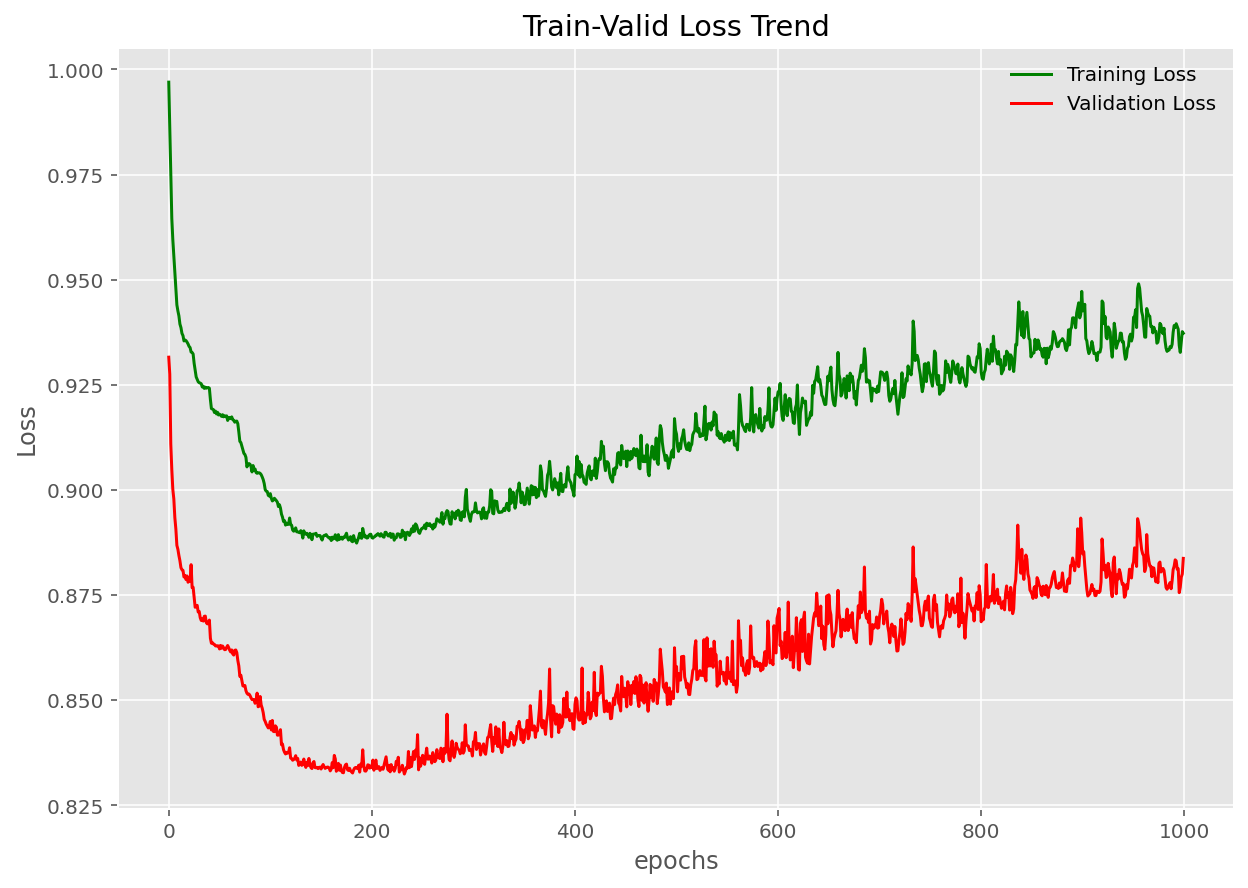

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Loss plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("Train-Valid Loss Trend")
plt.plot(train_losses, color='green', label='Training Loss')
# plt.plot(valid_losses, color='blue', label='Validation Loss')
plt.plot(test_mse, color='red', label='Validation Loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(saving_path + "loss_plot.png")
plt.show()

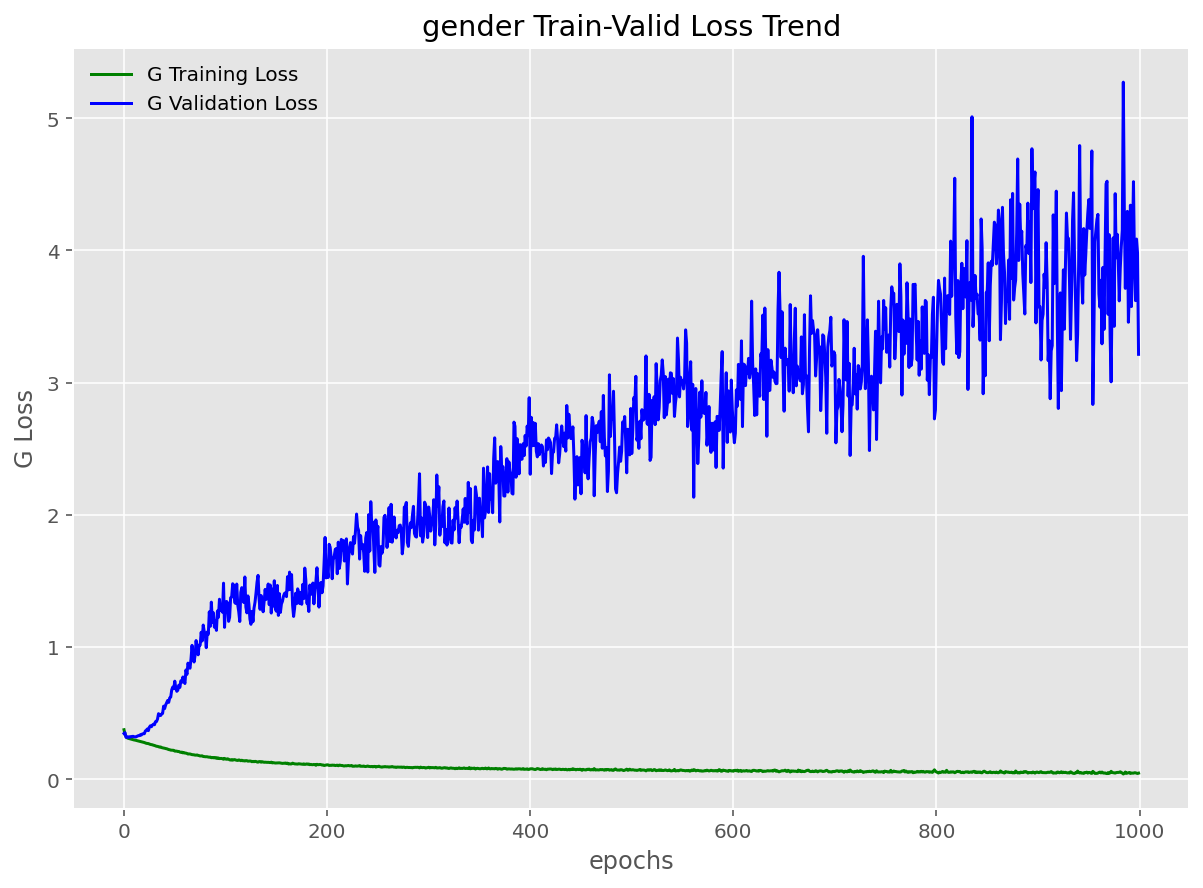

In [31]:
plt.figure(figsize=(10,7))
plt.title("gender Train-Valid Loss Trend")
plt.plot(y1_train_losses, color='green', label='G Training Loss')
plt.plot(y1_valid_losses, color='blue', label='G Validation Loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("G Loss")
plt.savefig(saving_path + "g_loss_plot.png")
plt.show()

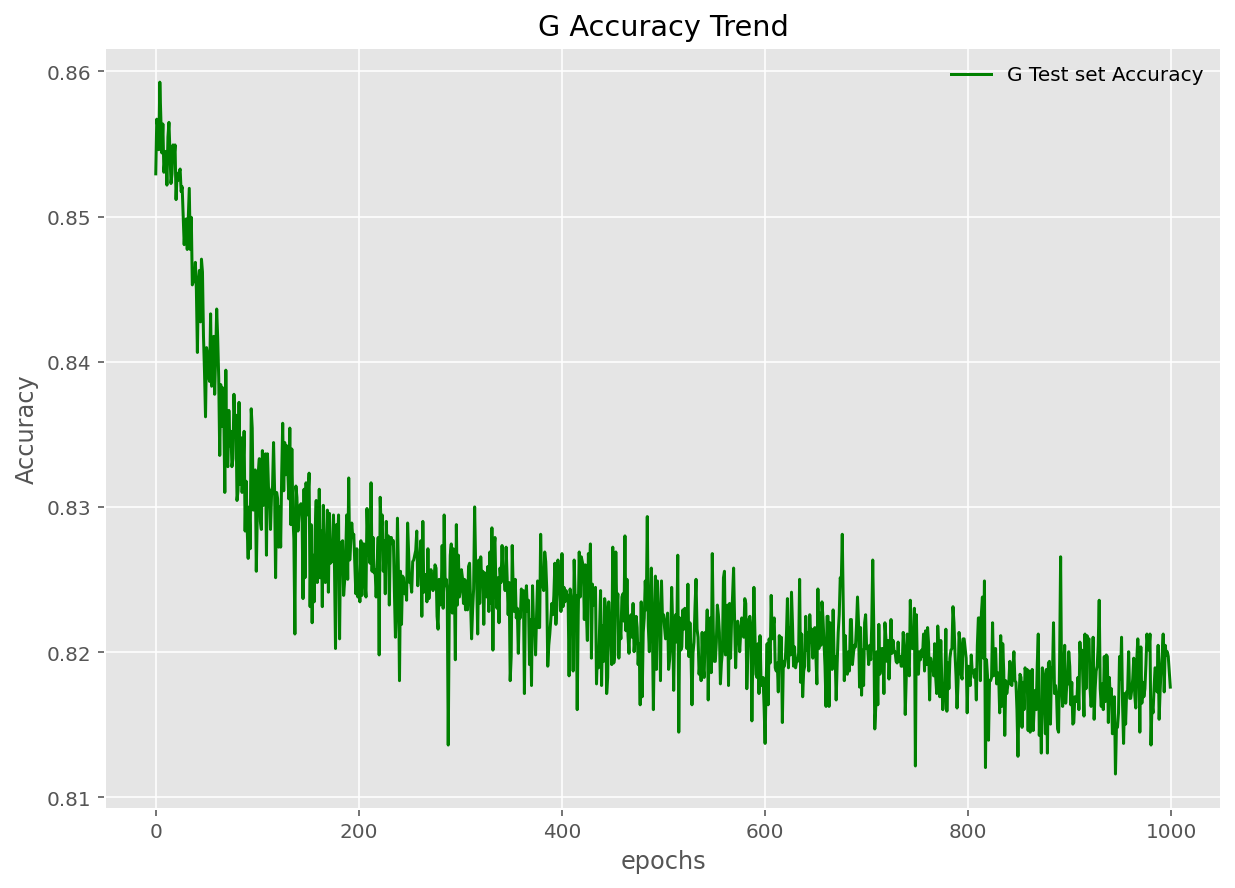

In [32]:

plt.figure(figsize=(10,7))
plt.title("G Accuracy Trend")
plt.plot(test_y1_acc, color='green', label='G Test set Accuracy')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig(saving_path + "accuracy_test_plot.png")
plt.show()

In [33]:
import operator
indexed = list(enumerate(test_y1_acc[175:]))
top_5 = sorted(indexed, key=operator.itemgetter(1))[-5:]
print(list(reversed([i+175 for i, v in top_5])))
print(list(reversed([v for i, v in top_5])))

[190, 212, 221, 314, 208]
[0.8320035460992907, 0.8316710992907801, 0.8306737588652482, 0.8300088652482269, 0.82989804964539]


In [34]:
len(test_y1_acc)

1000